# Context:

Ola is a leading ride-sharing platform, aiming to provide reliable, affordable, and convenient urban transportation for everyone. The constant challenge Ola faces is the churn rate of its drivers. Ensuring driver loyalty and reducing attrition are crucial to the company's operation.

# Problem Statement

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

- Demographics (city, age, gender etc.)
- Tenure information (joining date, Last Date)
- Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

● Analyzing driver data can reveal patterns in driver behavior, performance, and satisfaction. This would help in foreseeing potential churn, allowing proactive measures.

● By leveraging data science and ensemble learning, Ola can predict driver churn, which would be pivotal in its driver retention strategy.

● Analyzing the dataset to predict driver attrition. 

● Utilize ensemble learning techniques, evaluate the performance of your models, and provide actionable
insights to reduce driver churn.

● The main aim is to predict potential driver churn using multiple attributes to maintain a consistent driver base and ensure business continuity.


# Column Profiling:

- **MMMM-YY** : Reporting Date (Monthly)
- **Driver_ID** : Unique id for drivers
- **Age** : Age of the driver
- **Gender** : Gender of the driver – Male : 0, Female: 1
- **City** : City Code of the driver
- **Education_Level** : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
- **Income** : Monthly average Income of the driver
- **Date Of Joining** : Joining date for the driver
- **LastWorkingDate** : Last date of working for the driver
- **Joining Designation** : Designation of the driver at the time of joining
- **Grade** : Grade of the driver at the time of reporting
- **Total Business Value** : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
- **Quarterly Rating** : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

### Concepts Tested:

- Ensemble Learning- Bagging
- Ensemble Learning- Boosting
- KNN Imputation of Missing Values
- Working with an imbalanced dataset

# Importing Libraries

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kendalltau, pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn import metrics
import xgboost
import lightgbm
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold, cross_validate
from scipy.stats import uniform, randint
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, roc_auc_score

In [112]:
import warnings

warnings.filterwarnings('ignore') 

In [3]:
orig_data = pd.read_csv("ola_driver_scaler.csv")
orig_data.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


Observations:
1. The column 'Unnamed: 0' can be dropped.
2. Since the dataset contains multiple data for each driver, we can group it by Driver_ID.
3. The column 'MMM-YY' can be used to sort the data for each driver for the grouping.
4. The most recent value in the Age, Gender, City, Education_level, Income, Dateofjoining, LastWorkingDate, Joining Designation, Grade column can be used.
5. The Sum of 'Total Business Value'.
6. Get the average 'Quarterly Rating'(This can be compared with the most recent rating to see if the rating reduced or increased in the recent times than in past), 'avg_Income'(captures incase there are multiple incomes in the history) - This can be checked against 'Income' to see if there are multiple incomes.
7. Create a new column 'tenure in months', 'Most recent rating', 'churned' (yes-1/no-0)

In [4]:
orig_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


Observations:
1. The MMM-YY, City, Dateofjoining, LastWorkingDate features are object types.
2. Age and Gender are in float type.
3. Rest of the features are int types. 

In [5]:
orig_data.isnull().sum()

Unnamed: 0                  0
MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

Observations:
1. There are missing data in Age, Gender and LastWrokingDate features.
2. The datapoints that are missing LastworkingDate mostly will belong to drivers who have not left the company. There will be missing LastWorkingDates for drivers who left the company also. However that will be their past data. This will be considered in the grouping strategy.
3. The missing data in Age and Gender might also get fixed in the grouping process.

In [6]:
orig_data.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,19104.0,NaN,NaN,NaN,9551.5,5514.994107,0.0,4775.75,9551.5,14327.25,19103.0
MMM-YY,19104,24,01/01/19,1022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Driver_ID,19104.0,NaN,NaN,NaN,1415.591133,810.705321,1.0,710.0,1417.0,2137.0,2788.0
Age,19043.0,NaN,NaN,NaN,34.668435,6.257912,21.0,30.0,34.0,39.0,58.0
Gender,19052.0,NaN,NaN,NaN,0.418749,0.493367,0.0,0.0,0.0,1.0,1.0
City,19104,29,C20,1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Level,19104.0,NaN,NaN,NaN,1.021671,0.800167,0.0,0.0,1.0,2.0,2.0
Income,19104.0,NaN,NaN,NaN,65652.025126,30914.515344,10747.0,42383.0,60087.0,83969.0,188418.0
Dateofjoining,19104,869,23/07/15,192,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LastWorkingDate,1616,493,29/07/20,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observations:
1. The Age variable ranges from 21 to 58. The distribution of the Age variable is near normal distribution. At least 50% of the drivers are above 34 years old. Atleast 75% of the drivers are less than or equal to 39 years.
2. More than 50% of the drivers belong to Gender 0. Atleast 25% of the drivers belong to Gender 1.
3. There are 29 categories in the City variable. Most number of drivers are from the city C20.
4. There are 3 Education levels in the dataset (0,1,2). Atleast 25% of the drivers have education level as 0, atleast 25% of the drivers have education level as 2.
5. The monthly income of the drivers range from 10747 to 188418. The income variable is right skewed since the mean is greater than median.
6. The most number of drivers (192) have their Dateofjoining as 23/07/15.
7. Approximately 1616 rows have data in the LastWorkingDate feature. About 70 drivers have the LastWorkingDate as 29/07/20.
8. Atleast 50% of the data has Joining Designation as 1.
9. Atleast 25% of the data in the dataset has Grade as 1.
10. The total business value ranges from -6000000 to 33747720. At least 25% of the values in Total Business Value variable are 0 or less than 0. The distribution is right skewed. The mean is larger than median.
11. At least 25% of the drivers have got Quarterly rating as 1.

In [7]:
def analyze_cat_variable(df, col, plot_size = None, xtick_rotate = 0, hue = None):
    """
    This function uses the seaboarn and matplotlib to create countplots
    """
    null_count = df[col].isnull().sum()
    if null_count:
        print(f"There are {null_count} missing values in {col}.")
    if hue == None:
        print(f"There are {df[col].nunique()} categories in {col}.")
    if df[col].nunique() < 66:
        plt.figure(figsize = plot_size)
        sns.countplot(data = df, x = col, hue = hue)
        plt.xticks(rotation = xtick_rotate)
        plt.show()
    if hue == None:
        if df[col].nunique() < 11:
            print("Percentage of data:")
            print(df[col].value_counts()/df.shape[0]*100)
        else:
            print(f"Top 5 categories in {col}:")
            print(df[col].value_counts().head()/df.shape[0]*100)
            print("-"*20)
            print(f"Bottom 5 categories in {col}:")
            print(df[col].value_counts().sort_values(ascending = True).head()/df.shape[0]*100)


In [8]:
def analyze_cont_variable_plts(df, x, hue = None, kde = False, plot_size = None):
    """
    This function uses seaborn and matplotlib to create hisplot, boxplot in subplots.
    """
    null_count = df[x].isnull().sum()
    if null_count:
        print(f"There are {null_count} missing values in {x}.")
    if hue:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=plot_size)
        #plt.subplot(1,2,1)
        sns.histplot(data = df, x = x, kde = kde, ax = ax1)
        
        #plt.subplot(1,2,2)
        sns.histplot(data = df, x = x, kde = kde, hue = hue, ax = ax2)
        
        #plt.subplot(2,2,1)
        sns.boxplot(data = df, y = x, ax = ax3)
        
        #plt.subplot(2,2,2)
        sns.boxplot(data = df, x = hue, y = x, ax = ax4)
    else:
        plt.subplot(1,2,1)
        sns.histplot(data = df, x = x, kde = kde)
        plt.subplot(1,2,2)
        sns.boxplot(data = df, y = x)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, 
                    top=0.9, wspace=0.4,hspace=0.4)
    plt.show()

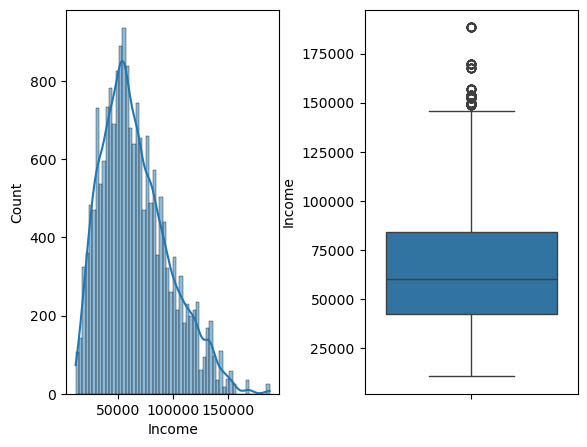

In [9]:
analyze_cont_variable_plts(orig_data, 'Income', kde = True)

Observations:
1. The income variable is right skewed and has some outliers in it.

There are 61 missing values in Age.
There are 36 categories in Age.


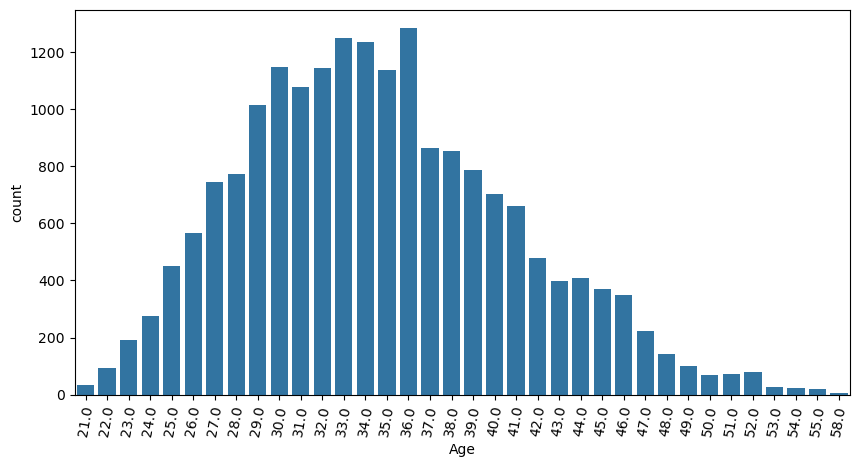

Top 5 categories in Age:
Age
36.0    6.715871
33.0    6.543132
34.0    6.459380
30.0    5.998744
32.0    5.983040
Name: count, dtype: float64
--------------------
Bottom 5 categories in Age:
Age
58.0    0.036642
55.0    0.109925
54.0    0.125628
53.0    0.136097
21.0    0.183208
Name: count, dtype: float64


In [10]:
analyze_cat_variable(orig_data, 'Age',plot_size = (10,5),xtick_rotate=80)

Observations:
1. Most of the drivers are between the age 29 to 41. The age variable is distributed in a near normal distribution.

There are 29 categories in City.


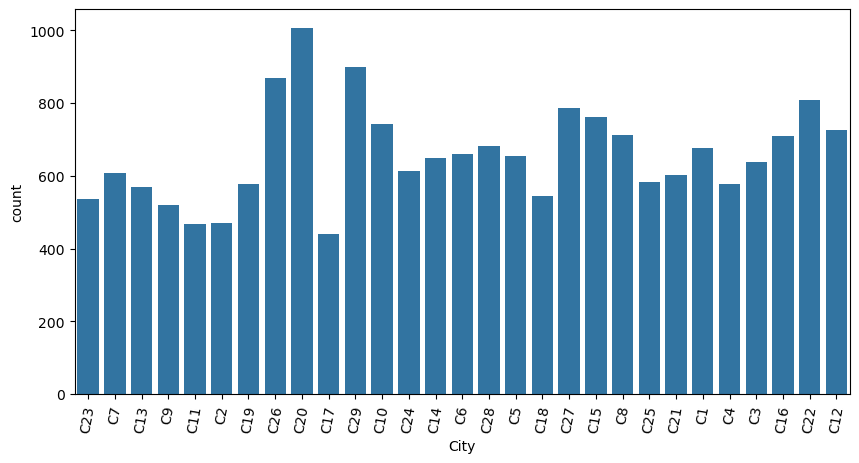

Top 5 categories in City:
City
C20    5.276382
C29    4.711055
C26    4.548786
C22    4.234715
C27    4.114322
Name: count, dtype: float64
--------------------
Bottom 5 categories in City:
City
C17    2.303183
C11    2.449749
C2     2.470687
C9     2.721943
C23    2.816164
Name: count, dtype: float64


In [11]:
analyze_cat_variable(orig_data, 'City',plot_size = (10,5),xtick_rotate=80)

Observations:
1. Most of the reportings are from the city of C20, followed by C29 and C26.
2. Least number of reportings are from the city C17.

There are 3 categories in Education_Level.


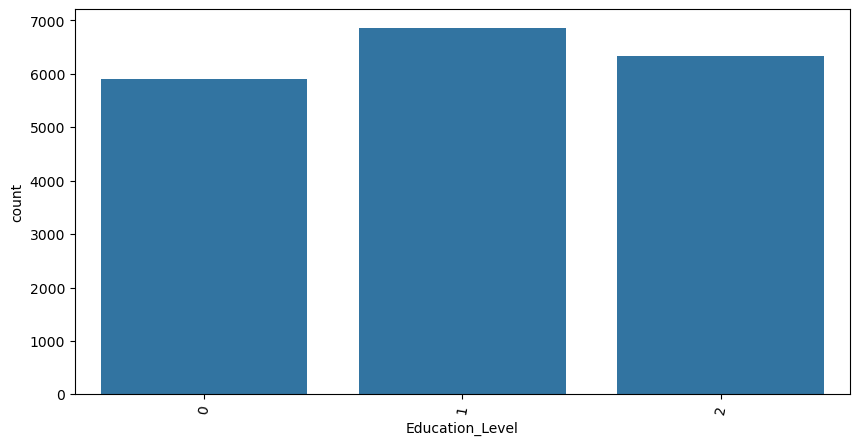

Percentage of data:
Education_Level
1    35.929648
2    33.118719
0    30.951633
Name: count, dtype: float64


In [12]:
analyze_cat_variable(orig_data, 'Education_Level',plot_size = (10,5),xtick_rotate=80)

Observations:
1. Most of the drivers have education level as 1. The 2nd most education level among the drivers is 2 and the least number of drivers have education level as 0.

There are 5 categories in Joining Designation.


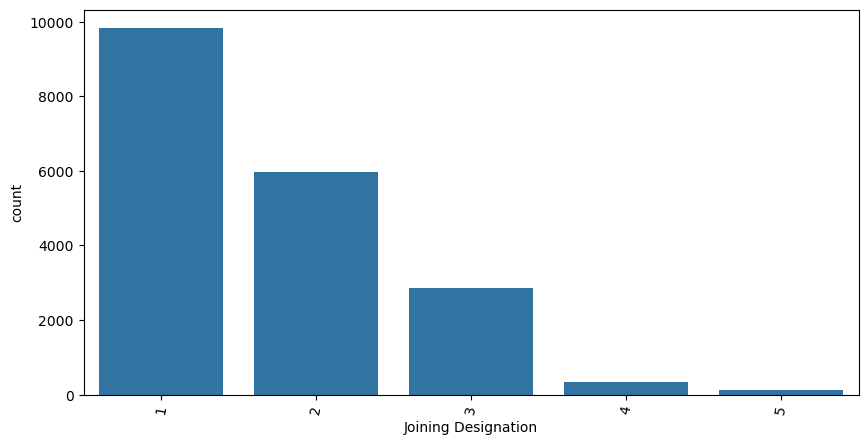

Percentage of data:
Joining Designation
1    51.460427
2    31.171482
3    14.902638
4     1.784966
5     0.680486
Name: count, dtype: float64


In [13]:
analyze_cat_variable(orig_data, 'Joining Designation',plot_size = (10,5),xtick_rotate=80)

Observations:
1. Most of the drivers in the dataset have Joining Designation as 1. Slightly more than 51% of the drivers have joining designation as 1.
2. The least number of drivers have joining designation as 5. Only around 0.68% of the drivers are in this category.

There are 5 categories in Grade.


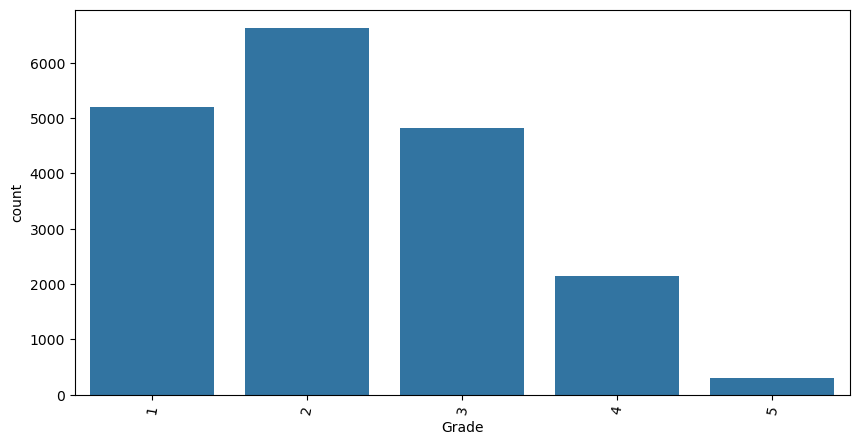

Percentage of data:
Grade
2    34.689070
1    27.229899
3    25.261725
4    11.222781
5     1.596524
Name: count, dtype: float64


In [14]:
analyze_cat_variable(orig_data, 'Grade',plot_size = (10,5),xtick_rotate=80)

Observations:
1. Most of the drivers' Grade is 2 with 34.6% of the drivers in this bucket.
2. Only 1.6% of the drivers fall in the Grade 5 bucket.

There are 4 categories in Quarterly Rating.


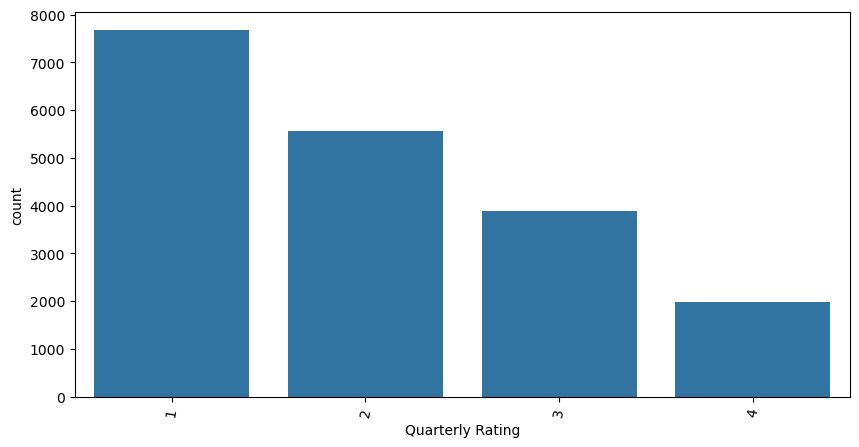

Percentage of data:
Quarterly Rating
1    40.195771
2    29.067211
3    20.388400
4    10.348618
Name: count, dtype: float64


In [15]:
analyze_cat_variable(orig_data, 'Quarterly Rating',plot_size = (10,5),xtick_rotate=80)

Observations:
1. Only 10% of the drivers have received Quarterly Rating as 4. This is the bucket with the least count.
2. The Quarterly Rating 1 bucket has the highest number of drivers in it. 

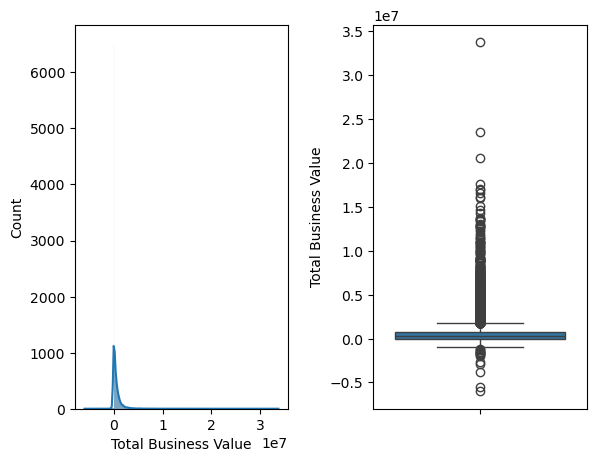

In [16]:
analyze_cont_variable_plts(orig_data, 'Total Business Value', kde = True)

Observations:
1. Most of the Total Business Values in the dataset are less than 50k and around 0.
2. There are so many outliers in the Total Business Value.

In [17]:
orig_data['Quarterly Rating'].value_counts()/orig_data.shape[0]*100

Quarterly Rating
1    40.195771
2    29.067211
3    20.388400
4    10.348618
Name: count, dtype: float64

Observations:
1. The drivers in the dataset have received Quarterly rating between 1 to 4.
2. About 40.19% of the drivers have received Quarterly Rating as 1.
3. 29.06% of the drivers have received Quarterly Rating as 2.
4. 20.38% of the drivers have received Quarterly Rating as 3.
5. 10.35% of the drivers have received Quarterly Rating as 4.

In [18]:
date_features = ['MMM-YY','Dateofjoining','LastWorkingDate']
orig_data[date_features] = orig_data[date_features].astype('datetime64[ns]')
orig_data.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,2019-01-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,2381060,2
1,1,2019-02-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,-665480,2
2,2,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,0,2
3,3,2020-11-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1
4,4,2020-12-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1


#### Extracting tenure, day, month and year from Dateofjoining and the LastWorkingDate and marking the Churned feature using LastWorkingDate.

In [19]:
orig_data['tenure'] = orig_data.groupby(['Driver_ID'])['Driver_ID'].transform('count')

orig_data['joining_day'] = orig_data['Dateofjoining'].dt.day
orig_data['joining_month'] = orig_data['Dateofjoining'].dt.month
orig_data['joining_year'] = orig_data['Dateofjoining'].dt.year

orig_data['leaving_day'] = orig_data['LastWorkingDate'].dt.day
orig_data['leaving_month'] = orig_data['LastWorkingDate'].dt.month
orig_data['leaving_year'] = orig_data['LastWorkingDate'].dt.year

#Creating the target variable
orig_data['churned'] = orig_data['LastWorkingDate'].isnull().map({True:0, False:1})
orig_data.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,...,Total Business Value,Quarterly Rating,tenure,joining_day,joining_month,joining_year,leaving_day,leaving_month,leaving_year,churned
0,0,2019-01-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,...,2381060,2,3,24,12,2018,NaN,NaN,NaN,0
1,1,2019-02-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,...,-665480,2,3,24,12,2018,NaN,NaN,NaN,0
2,2,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,...,0,2,3,24,12,2018,11.0,3.0,2019.0,1
3,3,2020-11-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,...,0,1,2,6,11,2020,NaN,NaN,NaN,0
4,4,2020-12-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,...,0,1,2,6,11,2020,NaN,NaN,NaN,0


## Missing value imputation

In [20]:
orig_data.isnull().sum()

Unnamed: 0                  0
MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
tenure                      0
joining_day                 0
joining_month               0
joining_year                0
leaving_day             17488
leaving_month           17488
leaving_year            17488
churned                     0
dtype: int64

Observations:
1. There are missing values in Age, Gender, last working date and its associated features.
2. Since the dataset is going to be merged, lets see if the missing values goes away. The missing values will go away if the values are available for other rows for the same driver.
3. KNNImputer can be used to impute the missing data.

In [21]:
from sklearn.impute import KNNImputer

In [22]:
X = orig_data.drop(['Unnamed: 0','MMM-YY','Dateofjoining','LastWorkingDate','leaving_day','leaving_month','leaving_year'], axis = 1)
X.head()
X['City'] = X['City'].apply(lambda x: int(x.replace("C","")))
X.isnull().sum()

Driver_ID                0
Age                     61
Gender                  52
City                     0
Education_Level          0
Income                   0
Joining Designation      0
Grade                    0
Total Business Value     0
Quarterly Rating         0
tenure                   0
joining_day              0
joining_month            0
joining_year             0
churned                  0
dtype: int64

In [23]:
imputer = KNNImputer(n_neighbors = 3)
imputed_data = imputer.fit_transform(X)
imputed_data = pd.DataFrame(imputed_data,columns= X.columns)

In [24]:
imputed_data.isnull().sum()

Driver_ID               0
Age                     0
Gender                  0
City                    0
Education_Level         0
Income                  0
Joining Designation     0
Grade                   0
Total Business Value    0
Quarterly Rating        0
tenure                  0
joining_day             0
joining_month           0
joining_year            0
churned                 0
dtype: int64

Observations:
1. All the missing data are imputed by the KNN Imputer successfully.

### Grouping dataset by Driver_ID

In [25]:
grp_data_imp = imputed_data.groupby(['Driver_ID']).agg(age = ('Age', 'last'),
                                                gender = ('Gender','last'),
                                                city = ('City','last'),
                                                education_level =  ('Education_Level', 'last'),
                                                income_recent = ('Income','last'),
                                                income_avg = ('Income', 'mean'),
                                                doj = ('joining_day','last'),
                                                moj = ('joining_month','last'),
                                                yoj = ('joining_year','last'),
                                                j_desig = ('Joining Designation', 'last'),
                                                grade = ('Grade','last'),
                                                tot_bus_val = ('Total Business Value', 'sum'),
                                                quar_rating_recent = ('Quarterly Rating', 'last'),
                                                quart_rating_avg = ('Quarterly Rating', 'mean'),
                                                tenure = ('tenure','last'),
                                                churned = ('churned','last')
                                           )
grp_data_imp.reset_index(inplace =  True)
grp_data_imp.head()

,Driver_ID,age,gender,city,education_level,income_recent,income_avg,doj,moj,yoj,j_desig,grade,tot_bus_val,quar_rating_recent,quart_rating_avg,tenure,churned
0,1.0,28.0,0.0,23.0,2.0,57387.0,57387.0,24.0,12.0,2018.0,1.0,1.0,1715580.0,2.0,2.0,3.0,1.0
1,2.0,31.0,0.0,7.0,2.0,67016.0,67016.0,6.0,11.0,2020.0,2.0,2.0,0.0,1.0,1.0,2.0,0.0
2,4.0,43.0,0.0,13.0,2.0,65603.0,65603.0,7.0,12.0,2019.0,2.0,2.0,350000.0,1.0,1.0,5.0,1.0
3,5.0,29.0,0.0,9.0,0.0,46368.0,46368.0,9.0,1.0,2019.0,1.0,1.0,120360.0,1.0,1.0,3.0,1.0
4,6.0,31.0,1.0,11.0,1.0,78728.0,78728.0,31.0,7.0,2020.0,3.0,3.0,1265000.0,2.0,1.6,5.0,0.0


In [26]:
grp_data_imp['Driver_ID'].nunique()

2381

In [27]:
orig_data['Driver_ID'].nunique()

2381

Observations:
1. Expecting 2381 rows after grouping by driver id.

In [28]:
grp_data = orig_data.groupby(['Driver_ID']).agg(age = ('Age', 'last'),
                                                gender = ('Gender','last'),
                                                city = ('City','last'),
                                                education_level =  ('Education_Level', 'last'),
                                                income_recent = ('Income','last'),
                                                income_avg = ('Income', 'mean'),
                                                doj = ('joining_day','last'),
                                                moj = ('joining_month','last'),
                                                yoj = ('joining_year','last'),
                                                j_desig = ('Joining Designation', 'last'),
                                                grade = ('Grade','last'),
                                                tot_bus_val = ('Total Business Value', 'sum'),
                                                quar_rating_recent = ('Quarterly Rating', 'last'),
                                                quart_rating_avg = ('Quarterly Rating', 'mean'),
                                                tenure = ('tenure','last'),
                                                churned = ('churned','last')
                                           )
grp_data.reset_index(inplace =  True)
grp_data.shape

(2381, 17)

In [29]:
grp_data.isnull().sum()

Driver_ID             0
age                   0
gender                0
city                  0
education_level       0
income_recent         0
income_avg            0
doj                   0
moj                   0
yoj                   0
j_desig               0
grade                 0
tot_bus_val           0
quar_rating_recent    0
quart_rating_avg      0
tenure                0
churned               0
dtype: int64

Observations:
1. As expected, the missing values are taken care of by the grouping. Hence, this grouped data will be used in the remaining parts of the project to avoid synthetic data.

In [30]:
grp_data.head()

,Driver_ID,age,gender,city,education_level,income_recent,income_avg,doj,moj,yoj,j_desig,grade,tot_bus_val,quar_rating_recent,quart_rating_avg,tenure,churned
0,1,28.0,0.0,C23,2,57387,57387.0,24,12,2018,1,1,1715580,2,2.0,3,1
1,2,31.0,0.0,C7,2,67016,67016.0,6,11,2020,2,2,0,1,1.0,2,0
2,4,43.0,0.0,C13,2,65603,65603.0,7,12,2019,2,2,350000,1,1.0,5,1
3,5,29.0,0.0,C9,0,46368,46368.0,9,1,2019,1,1,120360,1,1.0,3,1
4,6,31.0,1.0,C11,1,78728,78728.0,31,7,2020,3,3,1265000,2,1.6,5,0


Observations:
1. The most recent quarterly rating and the average quarterly rating can be compared to tell whether the quarterly rating has increased for that driver or decreased.
2. A new feature can be created and values can be assigned as 1 for those whose quarterly rating has increased and 0 for those that stays the same and -1 for those that decreased.
3. For driver id 6, the most recent quarterly rating is 2 and the average quarterly rating is 1.6.
4. For driver id 2788, the most recent quarterly rating is 2 and the average is 2.285714 

In [31]:
orig_data[orig_data['Driver_ID'].isin([6,2788])]

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,...,Total Business Value,Quarterly Rating,tenure,joining_day,joining_month,joining_year,leaving_day,leaving_month,leaving_year,churned
13,13,2020-08-01,6,31.0,1.0,C11,1,78728,2020-07-31,NaT,...,0,1,5,31,7,2020,NaN,NaN,NaN,0
14,14,2020-09-01,6,31.0,1.0,C11,1,78728,2020-07-31,NaT,...,0,1,5,31,7,2020,NaN,NaN,NaN,0
15,15,2020-10-01,6,31.0,1.0,C11,1,78728,2020-07-31,NaT,...,0,2,5,31,7,2020,NaN,NaN,NaN,0
16,16,2020-11-01,6,31.0,1.0,C11,1,78728,2020-07-31,NaT,...,1265000,2,5,31,7,2020,NaN,NaN,NaN,0
17,17,2020-12-01,6,31.0,1.0,C11,1,78728,2020-07-31,NaT,...,0,2,5,31,7,2020,NaN,NaN,NaN,0
19097,19097,2020-06-01,2788,29.0,0.0,C27,2,70254,2020-06-08,NaT,...,0,1,7,8,6,2020,NaN,NaN,NaN,0
19098,19098,2020-07-01,2788,30.0,0.0,C27,2,70254,2020-06-08,NaT,...,497690,3,7,8,6,2020,NaN,NaN,NaN,0
19099,19099,2020-08-01,2788,30.0,0.0,C27,2,70254,2020-06-08,NaT,...,740280,3,7,8,6,2020,NaN,NaN,NaN,0
19100,19100,2020-09-01,2788,30.0,0.0,C27,2,70254,2020-06-08,NaT,...,448370,3,7,8,6,2020,NaN,NaN,NaN,0
19101,19101,2020-10-01,2788,30.0,0.0,C27,2,70254,2020-06-08,NaT,...,0,2,7,8,6,2020,NaN,NaN,NaN,0


Observations:
1. As expected, if the recent quarterly rating is greater than the average quarterly rating, it means that the quarterly rating has increased. 
2. If the recent quarterly rating is lesser than the average quarterly rating, it means that the quarterly rating has decreased.
3. If the recent quarterly rating and the average quarterly rating are the same, it means that the quarterly rating has not changed.

In [32]:
# finding if there is channge in quarterly rating
grp_data['change_in_quart_rat'] = grp_data.apply(lambda record: 
                                                 1 if record['quar_rating_recent'] > record['quart_rating_avg']
                                                 else (-1 if record['quar_rating_recent'] < record['quart_rating_avg']
                                                       else 0),
                                                 axis = 1)
grp_data.head()

,Driver_ID,age,gender,city,education_level,income_recent,income_avg,doj,moj,yoj,j_desig,grade,tot_bus_val,quar_rating_recent,quart_rating_avg,tenure,churned,change_in_quart_rat
0,1,28.0,0.0,C23,2,57387,57387.0,24,12,2018,1,1,1715580,2,2.0,3,1,0
1,2,31.0,0.0,C7,2,67016,67016.0,6,11,2020,2,2,0,1,1.0,2,0,0
2,4,43.0,0.0,C13,2,65603,65603.0,7,12,2019,2,2,350000,1,1.0,5,1,0
3,5,29.0,0.0,C9,0,46368,46368.0,9,1,2019,1,1,120360,1,1.0,3,1,0
4,6,31.0,1.0,C11,1,78728,78728.0,31,7,2020,3,3,1265000,2,1.6,5,0,1


The same logic applies to the income field also. We can create a column which tells whether the monthly income has increased for that driver - for those whose monthly income has increased we assign the value 1, for no chnage 0 and for decrese -1

In [33]:
# finding is there is change in income
grp_data['change_in_income'] = grp_data.apply(lambda record: 1 if record['income_recent'] > record['income_avg']
                                             else (-1 if record['income_recent'] < record['income_avg']
                                                  else 0),
                                             axis = 1)
grp_data.head()

,Driver_ID,age,gender,city,education_level,income_recent,income_avg,doj,moj,yoj,j_desig,grade,tot_bus_val,quar_rating_recent,quart_rating_avg,tenure,churned,change_in_quart_rat,change_in_income
0,1,28.0,0.0,C23,2,57387,57387.0,24,12,2018,1,1,1715580,2,2.0,3,1,0,0
1,2,31.0,0.0,C7,2,67016,67016.0,6,11,2020,2,2,0,1,1.0,2,0,0,0
2,4,43.0,0.0,C13,2,65603,65603.0,7,12,2019,2,2,350000,1,1.0,5,1,0,0
3,5,29.0,0.0,C9,0,46368,46368.0,9,1,2019,1,1,120360,1,1.0,3,1,0,0
4,6,31.0,1.0,C11,1,78728,78728.0,31,7,2020,3,3,1265000,2,1.6,5,0,1,0


In [34]:
grp_data['change_in_income'].value_counts()

change_in_income
 0    2337
 1      43
-1       1
Name: count, dtype: int64

In [35]:
grp_data[grp_data['change_in_income'] == -1]

,Driver_ID,age,gender,city,education_level,income_recent,income_avg,doj,moj,yoj,j_desig,grade,tot_bus_val,quar_rating_recent,quart_rating_avg,tenure,churned,change_in_quart_rat,change_in_income
502,582,33.0,1.0,C10,2,47682,48363.142857,25,11,2019,2,2,26819450,4,3.0,14,0,1,-1


Observations:
1. Since there is only one driver for whom the monthly income decreased, it does not have any significant impact on the data. Hence the feature can be 0 or 1 instead of 1, 0, -1.

In [36]:
grp_data['change_in_income'] = grp_data.apply(lambda record: 1 if record['income_recent'] > record['income_avg']
                                             else 0,
                                             axis = 1)
grp_data.head()

,Driver_ID,age,gender,city,education_level,income_recent,income_avg,doj,moj,yoj,j_desig,grade,tot_bus_val,quar_rating_recent,quart_rating_avg,tenure,churned,change_in_quart_rat,change_in_income
0,1,28.0,0.0,C23,2,57387,57387.0,24,12,2018,1,1,1715580,2,2.0,3,1,0,0
1,2,31.0,0.0,C7,2,67016,67016.0,6,11,2020,2,2,0,1,1.0,2,0,0,0
2,4,43.0,0.0,C13,2,65603,65603.0,7,12,2019,2,2,350000,1,1.0,5,1,0,0
3,5,29.0,0.0,C9,0,46368,46368.0,9,1,2019,1,1,120360,1,1.0,3,1,0,0
4,6,31.0,1.0,C11,1,78728,78728.0,31,7,2020,3,3,1265000,2,1.6,5,0,1,0


In [37]:
grp_data['change_in_income'].value_counts()

change_in_income
0    2338
1      43
Name: count, dtype: int64

Observations:
1. 43 out of 2338 drivers have had a positive change in their monthly income in the dataset.

In [38]:
grp_data['churned'].value_counts()/ grp_data.shape[0] * 100

churned
1    67.870643
0    32.129357
Name: count, dtype: float64

Observations:
1. The dataset is imbalanced with respect to the churned feature.
2. In the dataset, about 67% of the drivers have left the job from Ola.

In [39]:
#Categorize the "Age" feature into bins such as: 'Young' (18-30), 'Middle-aged' (31-50), 'Senior' (50+). This can help in
#identifying patterns based on age groups.
grp_data['age_cat'] = grp_data['age'].apply(lambda x: 
                                            'young' if ((x >= 18) and (x <= 30))
                                            else ('middle-aged' if ((x >= 31) and (x <= 50))
                                                else 'senior'))
grp_data.head()

,Driver_ID,age,gender,city,education_level,income_recent,income_avg,doj,moj,yoj,j_desig,grade,tot_bus_val,quar_rating_recent,quart_rating_avg,tenure,churned,change_in_quart_rat,change_in_income,age_cat
0,1,28.0,0.0,C23,2,57387,57387.0,24,12,2018,1,1,1715580,2,2.0,3,1,0,0,young
1,2,31.0,0.0,C7,2,67016,67016.0,6,11,2020,2,2,0,1,1.0,2,0,0,0,middle-aged
2,4,43.0,0.0,C13,2,65603,65603.0,7,12,2019,2,2,350000,1,1.0,5,1,0,0,middle-aged
3,5,29.0,0.0,C9,0,46368,46368.0,9,1,2019,1,1,120360,1,1.0,3,1,0,0,young
4,6,31.0,1.0,C11,1,78728,78728.0,31,7,2020,3,3,1265000,2,1.6,5,0,1,0,middle-aged


In [40]:
grp_data.isnull().sum()

Driver_ID              0
age                    0
gender                 0
city                   0
education_level        0
income_recent          0
income_avg             0
doj                    0
moj                    0
yoj                    0
j_desig                0
grade                  0
tot_bus_val            0
quar_rating_recent     0
quart_rating_avg       0
tenure                 0
churned                0
change_in_quart_rat    0
change_in_income       0
age_cat                0
dtype: int64

Observations:
1. As expected, after grouping the data the missing values are gone.

### Statistical Description

In [41]:
grp_data.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Driver_ID,2381.0,NaN,NaN,NaN,1397.559009,806.161628,1.0,695.0,1400.0,2100.0,2788.0
age,2381.0,NaN,NaN,NaN,33.663167,5.983375,21.0,29.0,33.0,37.0,58.0
gender,2381.0,NaN,NaN,NaN,0.410332,0.491997,0.0,0.0,0.0,1.0,1.0
city,2381,29,C20,152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education_level,2381.0,NaN,NaN,NaN,1.00756,0.81629,0.0,0.0,1.0,2.0,2.0
income_recent,2381.0,NaN,NaN,NaN,59334.157077,28383.666384,10747.0,39104.0,55315.0,75986.0,188418.0
income_avg,2381.0,NaN,NaN,NaN,59232.460484,28298.214012,10747.0,39104.0,55285.0,75835.0,188418.0
doj,2381.0,NaN,NaN,NaN,15.787484,9.371835,1.0,7.0,15.0,24.0,31.0
moj,2381.0,NaN,NaN,NaN,7.357413,3.143143,1.0,5.0,7.0,10.0,12.0
yoj,2381.0,NaN,NaN,NaN,2018.536329,1.609597,2013.0,2018.0,2019.0,2020.0,2020.0


Observations:
1. 'age' feature ranges from 21 to 58. The distribution is very close to normally distributed.
2. There are at least 50% of the drivers from 'gender' = 0 and at least 25% of the drivers have 'gender' = 1.
3. The dataset is taken from 29 states. Most number of reportings are from the city 'C20' which has 152 records.
4. education_level has 0,1,2 as categories. At least 25% of the drivers have education level as 0. At least another 25% of the drivers have an education level as 2.
5. The monthly income (income_recent) of the drivers vary in the range of 10747 to  188418. At least 50% of the drivers have a monthly income of greater than or equal to 55315. The income_recent variable is right skewed. The same information matches for the average income of the drivers also. The mean od income_avg slightly lesser than the mean of income_recent. This indicates that, there is slight increase in the income of few drivers recently.
6. At least 25% of the drivers in the data have joined the company in the year 2020. The dataset has drivers who are working since 2013.
7. The j_desig ranges from 1 to 5. At least 75% of the drivers have joined in the designation 1 or 2.
8. The grades are from 1 to 5. At least 25% of the drivers have grade as 1.
9. The tot_bus_val variable ranges from -1385530 to 95331060. There are negative values in the variable. The variable is heavily right skewed.
10. The quar_rating_recent variable is ordinal with values between 1 to 4. At least 50% of the drivers have received the most recent quarterly rating as 1.
11. quar_rating_avg shows the average quarterly rating for each driver. At least 50% of the drivers received quarterly rating as 1 on average.
12. The drivers have 1 to 24 months tenure in the dataset. All the drivers in the data have less than or equal to only 2 years. At least 75% of the drivers have tenure less than or equal to 10 months.
13. At least 50% of the drivers have left the company.
14. change_in_quart_rat shows values between -1 to 0. At least 25% of the drivers have a negative change in their quarterly rating. At least 25% of the drivers have no change in their quarterly rating.
15. change_in_income shows values between 0 and1. At least 75% of the drivers have a no change in their monthly income.

## Correlation

In [150]:
# this solved annot problem.
#problem was that only the 1st row was showing the annot values.
#!pip install seaborn --upgrade

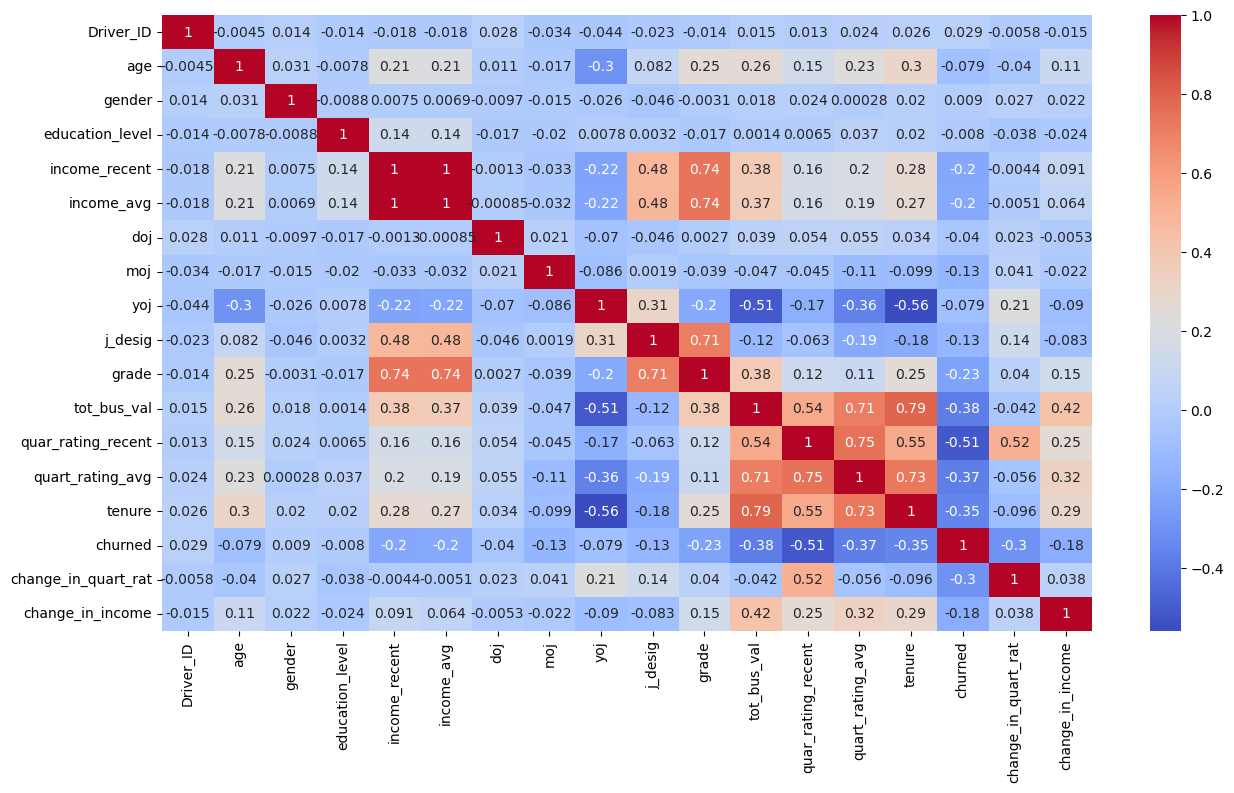

In [43]:
plt.figure(figsize = (15,8))
sns.heatmap(grp_data.select_dtypes(exclude = ['object']).corr(),cmap = "coolwarm", annot = True)
plt.show()

Observations:
1. The income_recent and the income_avg has a strong positive correlation with the grade with a correlation value of 0.74.
2. The j_design and grade have a positive correlation with each other with a correlation value of 0.71
3. The tot_bus_val has a strong positive correlation with tenure and the quar_rating_avg with values 0.79 and 0.71
4. The quart_rating_avg has a strong positive correlation with tenure with a value of 0.73.

## Outliers

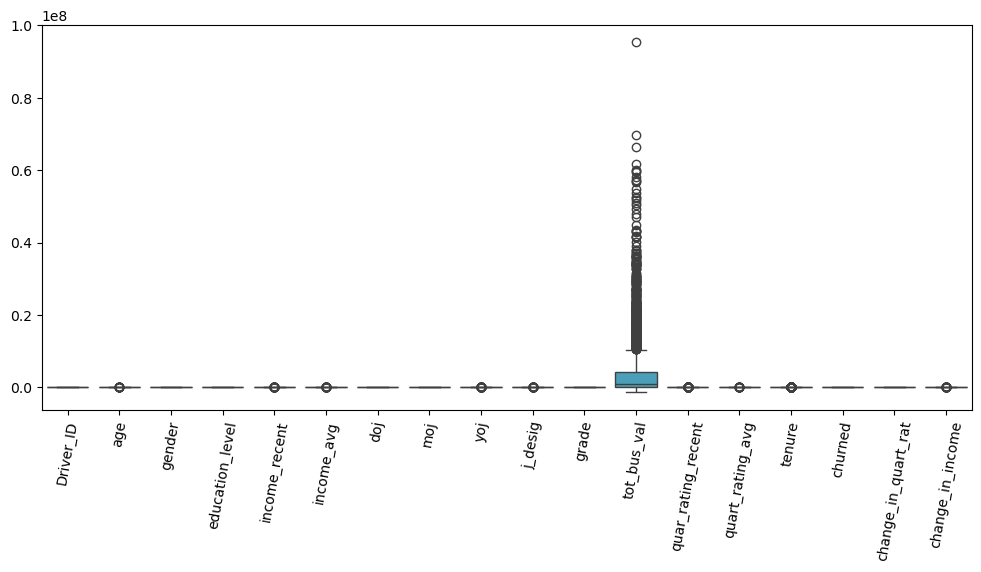

In [44]:
plt.figure(figsize = (12, 5))
sns.boxplot(grp_data)
plt.xticks(rotation = 80)
plt.show()

Observations:
1. There are extreme outliers in the tol_bus_val (Total Business Value). This can impact the Gradient Boosting Decision tree model by giving large residuals. This can disproportionately affect the creation of next base learners.
2. This needs to be treated.

##### Analyzing the outliers

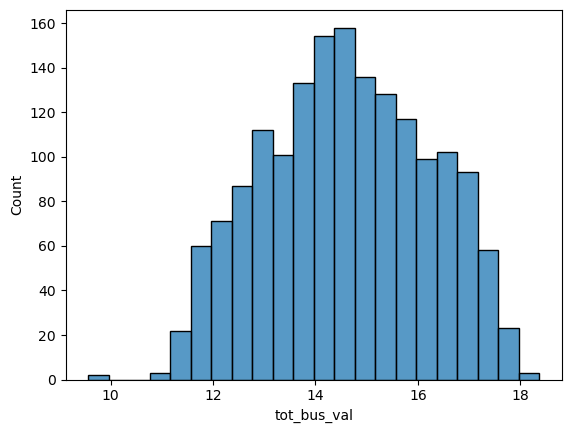

In [45]:
# Log transformation to treat the outliers
sns.histplot(x = np.log(np.abs(grp_data['tot_bus_val'])))
plt.show()

Observations:
1. The log transformation makes the distribution near normal.
2. However, since there are negative values in the tot_bus_val. This will be a problem in log transformation.

In [46]:
grp_data[grp_data['tot_bus_val'] < 0]

,Driver_ID,age,gender,city,education_level,income_recent,income_avg,doj,moj,yoj,j_desig,grade,tot_bus_val,quar_rating_recent,quart_rating_avg,tenure,churned,change_in_quart_rat,change_in_income,age_cat
47,61,32.0,0.0,C11,2,19818,19818.0,4,5,2018,1,1,-439300,1,1.0,3,1,0,0,middle-aged
106,127,33.0,0.0,C28,1,84085,84085.0,4,5,2018,3,3,-70000,1,1.0,3,1,0,0,middle-aged
739,868,24.0,1.0,C28,0,34497,34497.0,7,12,2018,2,2,-645150,1,1.0,4,1,0,0,young
792,930,37.0,1.0,C7,2,37285,37285.0,16,10,2018,1,1,-101180,1,1.0,1,1,0,0,middle-aged
917,1081,24.0,1.0,C5,2,55551,55551.0,14,5,2018,1,1,-96960,1,1.0,2,1,0,0,young
1100,1295,31.0,0.0,C23,2,51643,51643.0,29,4,2016,1,2,-14310,1,1.0,3,1,0,0,middle-aged
1495,1754,25.0,1.0,C10,2,42975,42975.0,9,1,2019,1,1,-500000,1,1.0,3,1,0,0,young
1532,1803,34.0,0.0,C3,2,52914,52914.0,9,5,2018,1,1,-1385530,1,1.0,7,1,0,0,middle-aged
1870,2197,49.0,1.0,C17,1,82179,82179.0,12,2,2018,2,2,-411250,1,1.0,9,1,0,0,middle-aged
2055,2412,35.0,1.0,C14,1,77848,77848.0,11,6,2019,3,3,-134880,1,1.0,3,1,0,0,middle-aged


Observations:
1. There are 10 datapoints with negative values in total business value. Negative values will be undefined if we use log transform. So a new feature is created to mark rows with negative tot_bus_val. Then use np.log1p() to add 1 after taking log of the value. This will help us do an addtive smoothing. ofr negative values.

In [47]:
# Feature engineering
grp_data['neg_tot_bus_val'] = grp_data['tot_bus_val'].apply(lambda x: 1 if x < 0 else 0)

In [48]:
# Feature engineering
grp_data['log_tot_bus_val'] = np.log1p(np.abs(grp_data['tot_bus_val']))

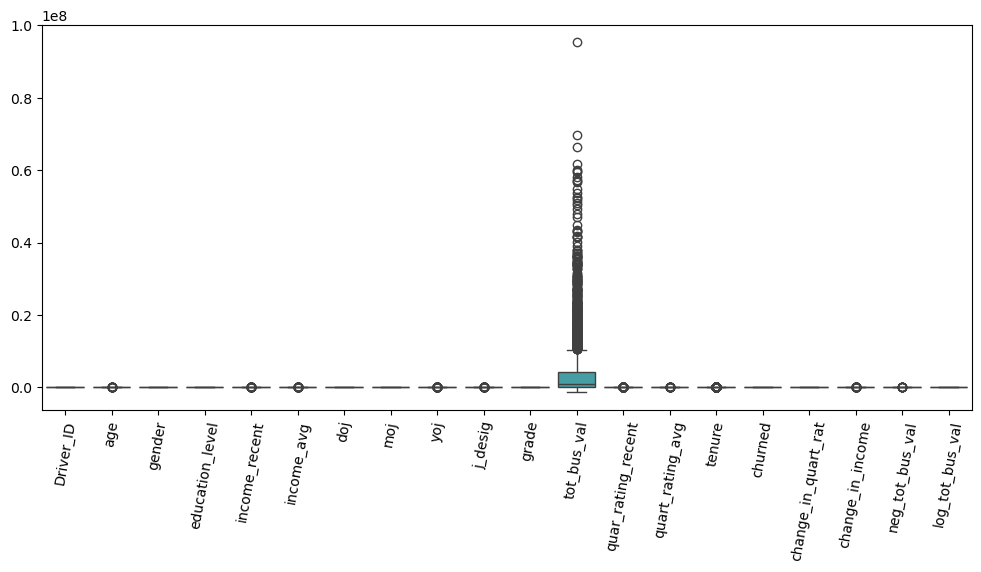

In [49]:
plt.figure(figsize = (12, 5))
sns.boxplot(grp_data)
plt.xticks(rotation = 80)
plt.show()

Observations:
1. The log transformation has successfully treated the outliers.

In [50]:
grp_data.isnull().sum()

Driver_ID              0
age                    0
gender                 0
city                   0
education_level        0
income_recent          0
income_avg             0
doj                    0
moj                    0
yoj                    0
j_desig                0
grade                  0
tot_bus_val            0
quar_rating_recent     0
quart_rating_avg       0
tenure                 0
churned                0
change_in_quart_rat    0
change_in_income       0
age_cat                0
neg_tot_bus_val        0
log_tot_bus_val        0
dtype: int64

In [51]:
grp_data[grp_data['log_tot_bus_val'] == -np.inf]

,Driver_ID,age,gender,city,education_level,income_recent,income_avg,doj,moj,yoj,...,tot_bus_val,quar_rating_recent,quart_rating_avg,tenure,churned,change_in_quart_rat,change_in_income,age_cat,neg_tot_bus_val,log_tot_bus_val


Observations:
1. The transformation has not introduced any null values or -inf values.

##### Relationship between age and quarterly rating

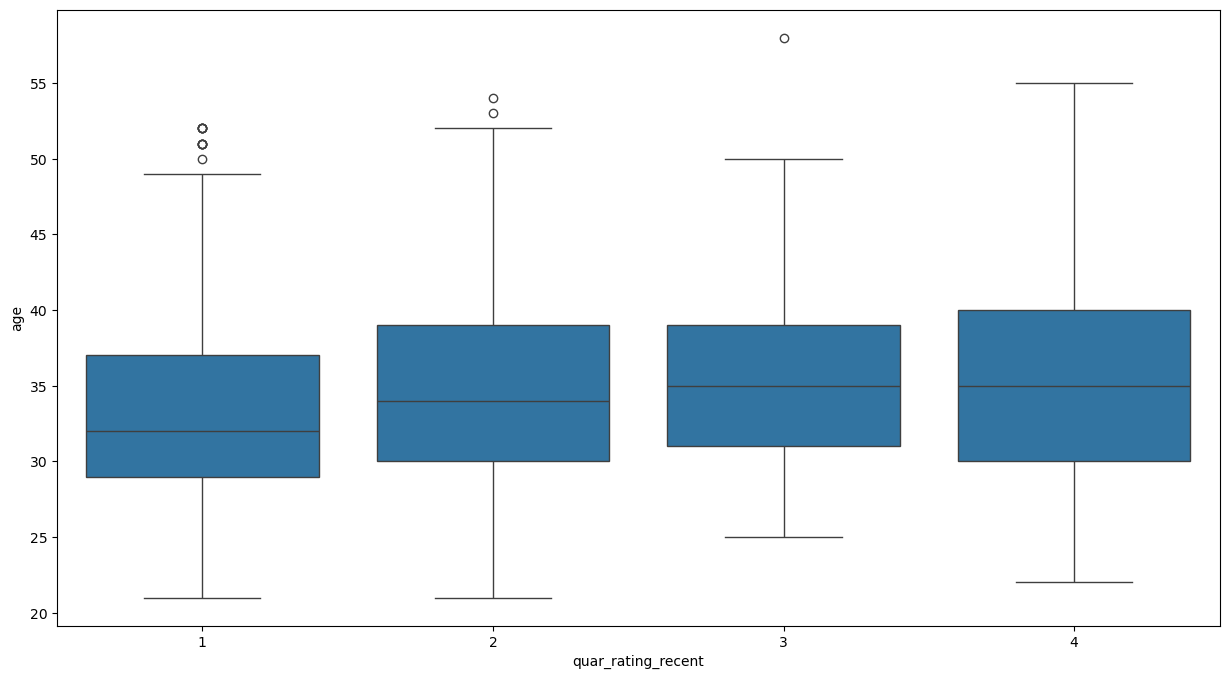

P value: 1.827140250113541e-12
Reject Null Hypothesis.
There is an association between the Age and Quarterly Ratings.


In [52]:
H0 = "There is no association between the Age and Quarterly Ratings."
H1 = "There is an association between the Age and Quarterly Ratings."

alpha = 0.05

tab = pd.crosstab(grp_data['age'], grp_data['quar_rating_recent'] )

plt.figure(figsize = (15,8))
sns.boxplot(data = grp_data, x = 'quar_rating_recent', y = 'age')
plt.show()

stat, p_value, dof, exp = stats.chi2_contingency(tab)
print("P value:",p_value)
if p_value > alpha:
    print("Failed to reject Null Hypothesis.")
    print(H0)
else:
    print("Reject Null Hypothesis.")
    print(H1)

Observations:
1. The boxplot shows an association between the Quarterly Rating and the age features. The rating 3 and 4 seem to be received more by slightly older drivers than ratings 1 and 2.
2. The Chi 2 contingency test confirms that there is an association between the age and the Quarterly Ratings features with a p value of 1.827140250113541e-12.

##### Seasonality in Quarterly Rating

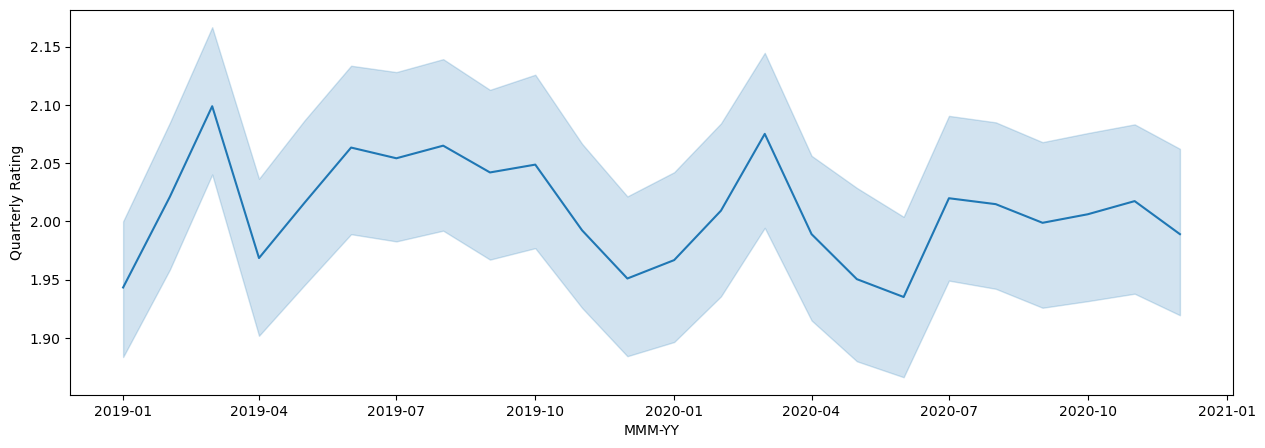

In [53]:
plt.figure(figsize = (15,5))
sns.lineplot(data = orig_data, x = 'MMM-YY', y = 'Quarterly Rating')
plt.show()

Observations:
1. There is a seasonality visually in the lineplot between the Reporting quarters and the Quarterly Ratings.
2. The Quarterly ratings seem to increase by the mid of 1st quarter and decreases by the end of 1st quater. Then increases again in the 2nd quarter by June and again decreases by october. This seasonal trend is similar for 2019 as well as 2020.
3. The highest peaks seem to be in the month of March in both 2019 and 2020.

##### Relationship between Cities and Quarterly Rating

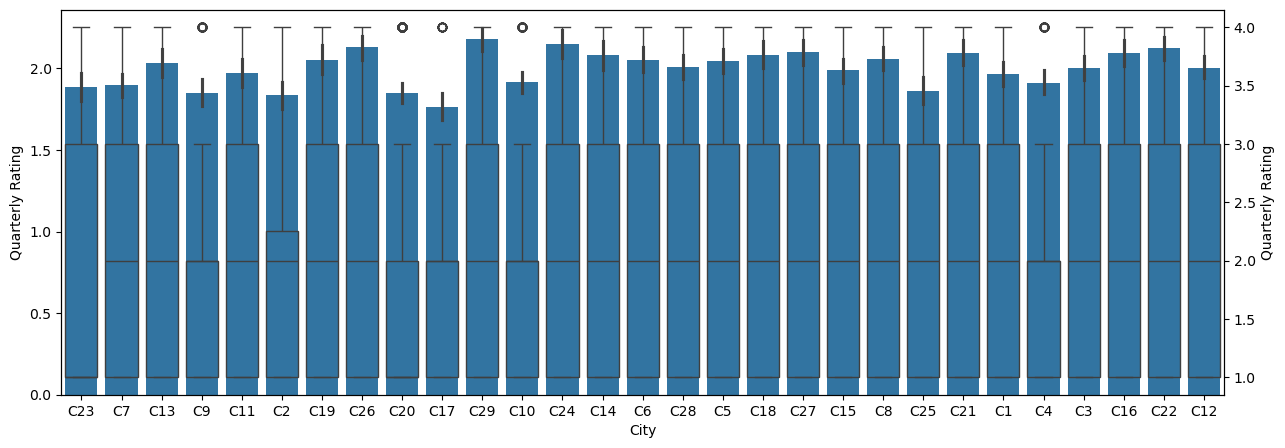

1.818744236174162e-60
Raject Null Hypothesis.
There is an association between the City and the Quarterly Ratings.


In [54]:

fig, ax1 = plt.subplots(figsize = (15,5))
ax2 = ax1.twinx()
sns.barplot(data = orig_data, x = 'City', y = 'Quarterly Rating', ax = ax1)
sns.boxplot(data = orig_data, x = 'City', y = 'Quarterly Rating', ax = ax2)

plt.show()

H0 = "There is no association between the City and the Quarterly Ratings."
H1 = "There is an association between the City and the Quarterly Ratings."
alpha = 0.05

tab = pd.crosstab(orig_data['Quarterly Rating'], orig_data['City'])
_, p_value, _, _ = stats.chi2_contingency(tab)
print(p_value)

if p_value < alpha:
    print("Raject Null Hypothesis.")
    print(H1)
else:
    print("Failed to reject the Null Hypothesis.")
    print(H0)

Observations:
1. Drivers in some cities like C21, C24, C27, C29 are consistently getting good quarterly ratings on a average.
2. Drivers in cities like C9, C20, C10 and C4 are consistently getting lower quarterly ratings.
3. The Chi 2 contingency test shows that there is an association between city and quarterly ratings. It may mean that the drivers' performance could be affected by the city they operate in.

##### Checking if city influences the performance of the drivers over the past year

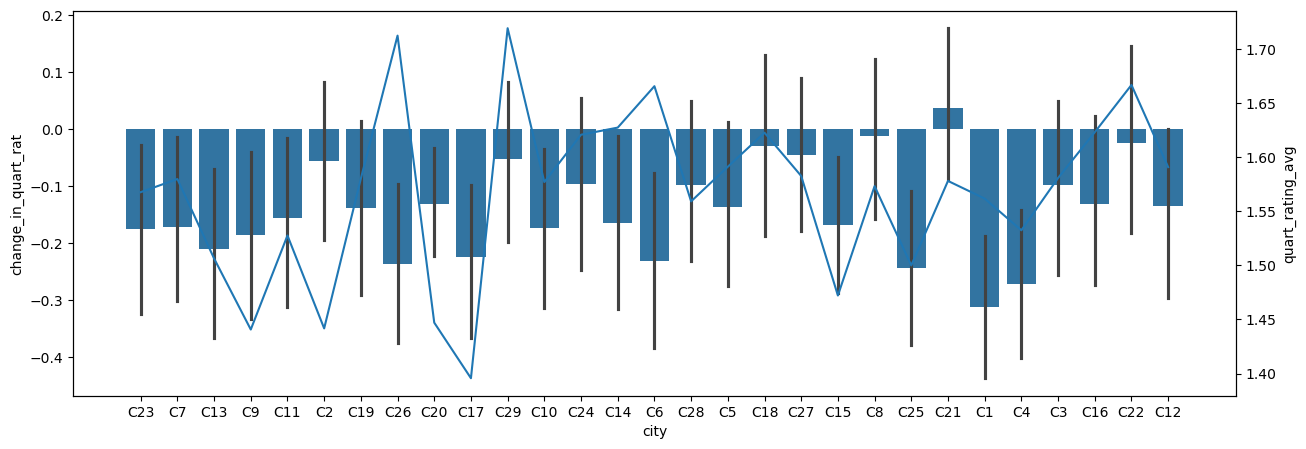

In [55]:

fig, ax1 = plt.subplots(figsize = (15,5))
ax2 = ax1.twinx()
sns.barplot(data = grp_data, x = 'city', y = 'change_in_quart_rat', estimator = 'mean',  ax=ax1)
sns.lineplot(data = grp_data, x = 'city', y = 'quart_rating_avg', ci = None,  ax=ax2)
plt.show()

Observations:
1. The city that shows the most improvement in the Quarterly rating over the past year is C21.
2. Most of the city shows a decrease in their drivers' quarterly ratings on an average. The city that shows the highest decrease in drivers' performances in terms of average quarterly ratings is C1.

In [56]:
orig_data[['MMM-YY', 'City', 'Quarterly Rating']]

,MMM-YY,City,Quarterly Rating
0,2019-01-01,C23,2
1,2019-02-01,C23,2
2,2019-03-01,C23,2
3,2020-11-01,C7,1
4,2020-12-01,C7,1
...,...,...,...
19099,2020-08-01,C27,3
19100,2020-09-01,C27,3
19101,2020-10-01,C27,2
19102,2020-11-01,C27,2


In [57]:
orig_data[orig_data['MMM-YY']>'2019-12-31']

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,...,Total Business Value,Quarterly Rating,tenure,joining_day,joining_month,joining_year,leaving_day,leaving_month,leaving_year,churned
3,3,2020-11-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,...,0,1,2,6,11,2020,NaN,NaN,NaN,0
4,4,2020-12-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,...,0,1,2,6,11,2020,NaN,NaN,NaN,0
6,6,2020-01-01,4,43.0,0.0,C13,2,65603,2019-12-07,NaT,...,0,1,5,7,12,2019,NaN,NaN,NaN,0
7,7,2020-02-01,4,43.0,0.0,C13,2,65603,2019-12-07,NaT,...,0,1,5,7,12,2019,NaN,NaN,NaN,0
8,8,2020-03-01,4,43.0,0.0,C13,2,65603,2019-12-07,NaT,...,350000,1,5,7,12,2019,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,19099,2020-08-01,2788,30.0,0.0,C27,2,70254,2020-06-08,NaT,...,740280,3,7,8,6,2020,NaN,NaN,NaN,0
19100,19100,2020-09-01,2788,30.0,0.0,C27,2,70254,2020-06-08,NaT,...,448370,3,7,8,6,2020,NaN,NaN,NaN,0
19101,19101,2020-10-01,2788,30.0,0.0,C27,2,70254,2020-06-08,NaT,...,0,2,7,8,6,2020,NaN,NaN,NaN,0
19102,19102,2020-11-01,2788,30.0,0.0,C27,2,70254,2020-06-08,NaT,...,200420,2,7,8,6,2020,NaN,NaN,NaN,0


### Check which city shows the most improvement in the Quarterly rating over last year.

1. We can look at the correlation betweent the reporting dates (MMM-YY) and the change in quarterly ratings for each city for the last one year in the datset. 
2. First we will find the change in the quarterly ratings over time for each city.
3. Then find the correlation strength between the MMM-YY column and the change in quarterly ratings to see if there is an increasing or decreasing trend. I will use the Kendall Tau correlation coefficient to find the strength of the trend.

The Kendall Tau correlation coefficient is a statistical measure that quantifies the strength and direction of a monotonic relationship between two variables. In simpler terms, it tells us how consistently one variable increases or decreases with the other.
- A **positive** Kendall Tau correlation coefficient indicates an **increasing trend**. This means that as time progresses, the Quarterly Rating for the city tends to increase. The closer the coefficient is to +1, the stronger this increasing trend is. Therefore, a city with a Kendall Tau correlation coefficient close to +1 has shown significant improvement in its Quarterly Rating over time.

- A **negative** Kendall Tau correlation coefficient indicates a **decreasing trend**. This means that as time progresses, the Quarterly Rating for the city tends to decrease. The closer the coefficient is to -1, the stronger this decreasing trend is.

- A Kendall Tau correlation coefficient close to **zero** indicates that there is **no trend**. This means that the Quarterly Rating for the city does not consistently increase or decrease over time.

So, by finding the city with the **maximum** Kendall Tau correlation coefficient, we're effectively finding the city that has shown the **most consistent improvement** in its Quarterly Rating over the past year.

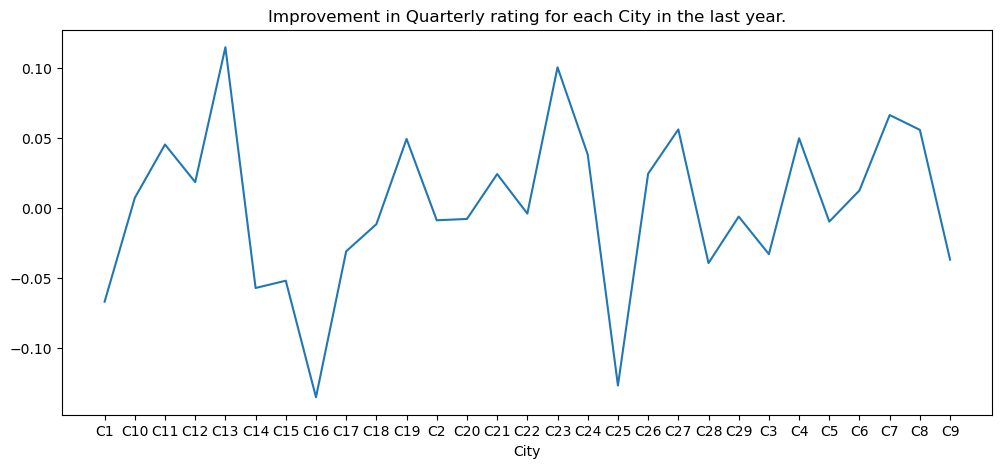

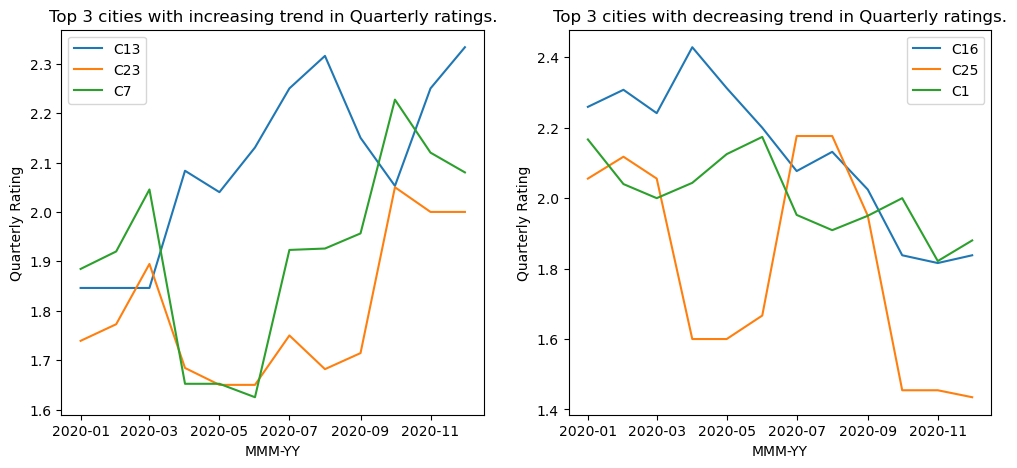

Cities that showed Top 5 most improvements:
City
C13    0.114907
C23    0.100573
C7     0.066471
C27    0.056171
C8     0.055850
dtype: float64
Cities that showed bottom 5 improvements:
City
C16   -0.135121
C25   -0.126750
C1    -0.066857
C14   -0.057086
C15   -0.051891
dtype: float64


In [58]:
#calculating the change in the quarterly rating for each city
orig_data['rating_change'] = orig_data.groupby('City')['Quarterly Rating'].diff()

#filtering out last one year data for the dataset
last_year = orig_data['MMM-YY'].max() - pd.DateOffset(years = 1)
last_year_df = orig_data[orig_data['MMM-YY'] > last_year]


city_trends  = last_year_df.groupby('City').apply(lambda x: kendalltau(x['MMM-YY'], x['Quarterly Rating']).correlation)

plt.figure(figsize = (12,5))
sns.lineplot(city_trends)
plt.title("Improvement in Quarterly rating for each City in the last year.")
plt.show()

fig, axes = plt.subplots(1, 2, figsize= (12,5), sharex = True)
sns.lineplot(ax=axes[0], data = last_year_df[last_year_df['City'] == 'C13'], x = 'MMM-YY', y = 'Quarterly Rating', ci = None, label = 'C13')
sns.lineplot(ax=axes[0], data = last_year_df[last_year_df['City'] == 'C23'], x = 'MMM-YY', y = 'Quarterly Rating', ci = None, label = 'C23')
sns.lineplot(ax=axes[0], data = last_year_df[last_year_df['City'] == 'C7'], x = 'MMM-YY', y = 'Quarterly Rating', ci = None, label = 'C7')
axes[0].set_title("Top 3 cities with increasing trend in Quarterly ratings.")

sns.lineplot(ax=axes[1], data = last_year_df[last_year_df['City'] == 'C16'], x = 'MMM-YY', y = 'Quarterly Rating', ci = None, label = 'C16')
sns.lineplot(ax=axes[1], data = last_year_df[last_year_df['City'] == 'C25'], x = 'MMM-YY', y = 'Quarterly Rating', ci = None, label = 'C25')
sns.lineplot(ax=axes[1], data = last_year_df[last_year_df['City'] == 'C1'], x = 'MMM-YY', y = 'Quarterly Rating', ci = None, label = 'C1')
axes[1].set_title("Top 3 cities with decreasing trend in Quarterly ratings.")

plt.legend()
plt.show()


print("Cities that showed Top 5 most improvements:")
print(city_trends.sort_values(ascending = False)[:5])
print("Cities that showed bottom 5 improvements:")
print(city_trends.sort_values(ascending = True)[:5])

Observations:
1. The cities C13, C23 and C7 shows the most improvements in the order in the quarterly ratings in the last year.
2. The cities C16, C25 and C1 showed the worst performance in terms of improvements in the Quarterly rating in the last year.

#### Drivers' grade and their Total Business Values

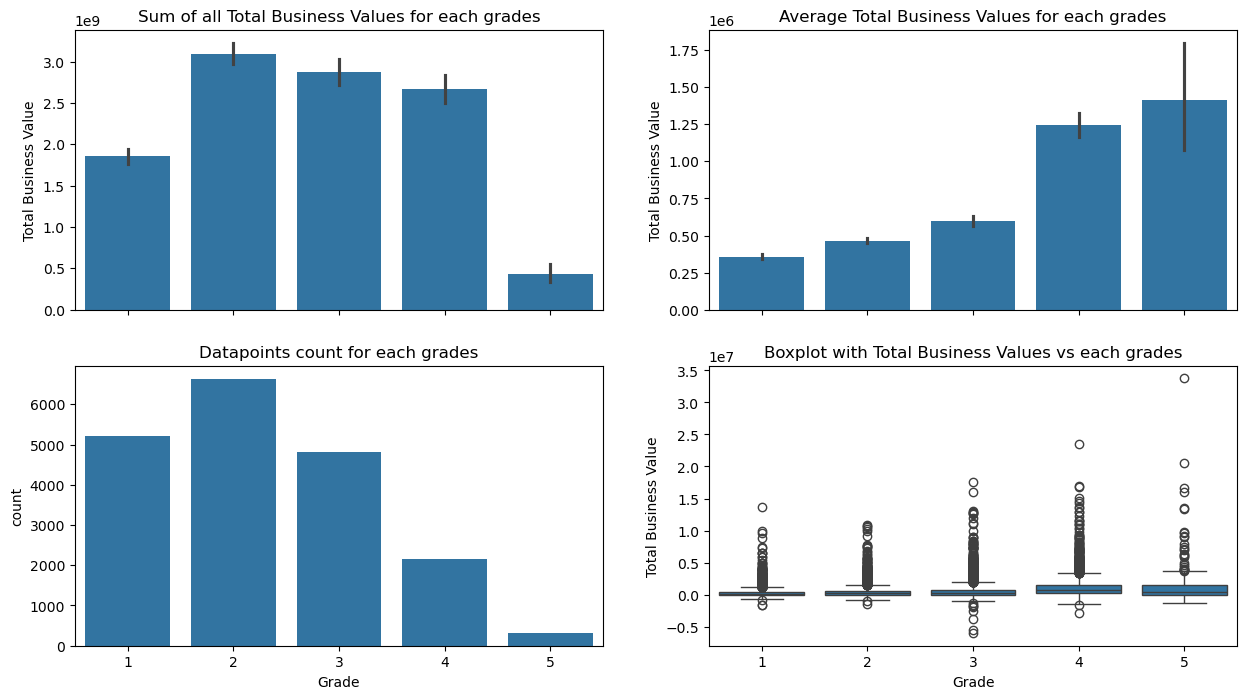

In [59]:
fig, ax = plt.subplots(2, 2, figsize = (15,8), sharex = True)

sns.barplot(data = orig_data, x = 'Grade', y = 'Total Business Value', estimator = 'sum', ax = ax[0,0])
ax[0,0].set_title("Sum of all Total Business Values for each grades")

sns.barplot(data = orig_data, x = 'Grade', y = 'Total Business Value', estimator = 'mean', ax = ax[0,1])
ax[0,1].set_title("Average Total Business Values for each grades")

sns.countplot(data = orig_data, x = 'Grade', ax = ax[1,0])
ax[1,0].set_title("Datapoints count for each grades")

sns.boxplot(data = orig_data, x = 'Grade', y = 'Total Business Value', ax = ax[1,1])
ax[1,1].set_title("Boxplot with Total Business Values vs each grades")

plt.show()

Observations:
1. The grades available in the dataset are 1, 2, 3, 4 and 5. 
2. On an average, the grade 5 tend to have the highest average Total Business Value followed by grade 4. Grade 1 has the least average Total Business Value.
3. In terms of sum of all Total Business Values, the grade 2 has the highest Total business Value followed by grade 3 and 4. Grade 5 has the least total business value.

#### Does the change in quarterly rating impact the total business value in the subsequent period

In [60]:
# Finding the change in the quarterly rating and the change in total business value.
orig_data['driver_rating_change'] = orig_data.groupby(['Driver_ID'])['Quarterly Rating'].diff()
orig_data['driver_tbv_change'] = orig_data.groupby(['Driver_ID'])['Total Business Value'].diff()

In [61]:
orig_data[['MMM-YY', 'Driver_ID','Quarterly Rating','rating_change','driver_tbv_change','driver_rating_change']]

,MMM-YY,Driver_ID,Quarterly Rating,rating_change,driver_tbv_change,driver_rating_change
0,2019-01-01,1,2,NaN,NaN,NaN
1,2019-02-01,1,2,0.0,-3046540.0,0.0
2,2019-03-01,1,2,0.0,665480.0,0.0
3,2020-11-01,2,1,NaN,NaN,NaN
4,2020-12-01,2,1,0.0,0.0,0.0
...,...,...,...,...,...,...
19099,2020-08-01,2788,3,0.0,242590.0,0.0
19100,2020-09-01,2788,3,0.0,-291910.0,0.0
19101,2020-10-01,2788,2,-1.0,-448370.0,-1.0
19102,2020-11-01,2788,2,0.0,200420.0,0.0


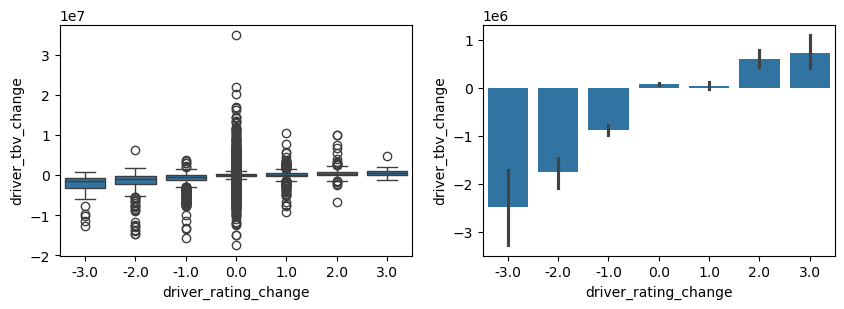

In [62]:
fig, ax = plt.subplots(1,2, figsize = (10,3))
sns.boxplot(data = orig_data, x = 'driver_rating_change', y = 'driver_tbv_change', ax = ax[0])
sns.barplot(data = orig_data, x = 'driver_rating_change', y = 'driver_tbv_change', ax = ax[1])
plt.show()

Observations:
1. Whenever there is a negative change in drivers' rating, we can see there is a negative change in the Total Business Value also. The medians of the 'change in total business value' for the negatively changing quarterly ratings are lesser than the medians of the change in total business value for the positively changing quarterly ratings.
2. The barplot shows that the average change in total business value see to be in negative (total business value reduces) whenever there is a negative change in the drivers' quarterly rating.

In [63]:
# Marking the drivers who have had a positive change in their quarterly rating vs no change vs negative change in their quarterly rating
orig_data['rating_change_trend'] = orig_data['driver_rating_change'].apply(lambda x: 1 if x > 0
                                                                          else (0 if ((x == 0) or (np.isnan(x)))
                                                                               else -1))
orig_data[['MMM-YY', 'Driver_ID','Quarterly Rating','rating_change','driver_tbv_change','driver_rating_change','rating_change_trend']]

,MMM-YY,Driver_ID,Quarterly Rating,rating_change,driver_tbv_change,driver_rating_change,rating_change_trend
0,2019-01-01,1,2,NaN,NaN,NaN,0
1,2019-02-01,1,2,0.0,-3046540.0,0.0,0
2,2019-03-01,1,2,0.0,665480.0,0.0,0
3,2020-11-01,2,1,NaN,NaN,NaN,0
4,2020-12-01,2,1,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...
19099,2020-08-01,2788,3,0.0,242590.0,0.0,0
19100,2020-09-01,2788,3,0.0,-291910.0,0.0,0
19101,2020-10-01,2788,2,-1.0,-448370.0,-1.0,-1
19102,2020-11-01,2788,2,0.0,200420.0,0.0,0


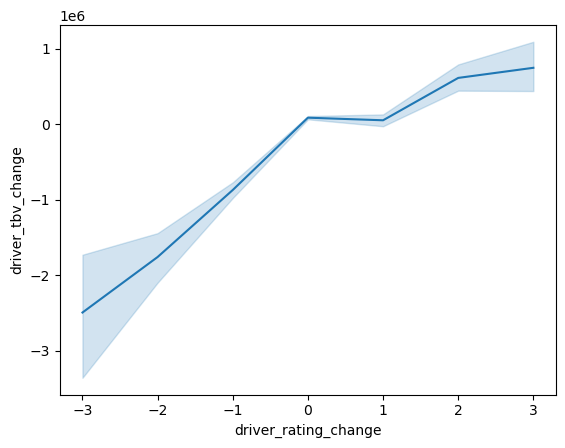

In [64]:
sns.lineplot(data = orig_data, x = 'driver_rating_change', y = 'driver_tbv_change')
plt.show()

Observations:
1. There is a trend that shows that if a driver gets a decreased quarterly rating, it impacts the total business value generated by the driver.

##### Statistical test to see if negative change in quarterly rating rating impacts the total business value negatively

In [65]:
from scipy.stats import f_oneway, ttest_ind

In [66]:
x1 = orig_data.loc[orig_data['rating_change_trend'] == -1, 'driver_tbv_change']
x1 = [0 if np.isnan(i) else i for i in x1]
x2 = orig_data.loc[orig_data['rating_change_trend'] == 0, 'driver_tbv_change']
x2 = [0 if np.isnan(i) else i for i in x2]
x3 = orig_data.loc[orig_data['rating_change_trend'] == 1, 'driver_tbv_change']
x3 = [0 if np.isnan(i) else i for i in x3]

H0 = "There is no difference among average change in total business values."
Ha = "At least one group differs significantly from the average change in total business values."

h0 = "The average change in total business values for drivers with negative change in quarterly rating and positive change in quarterly rating are the same."
ha = "The average change in total business values for drivers with negative change in quarterly rating is lesser than the average change in total business values for drivers with positve change in quarterly rating."
alpha = 0.05

_, p_value_oneway = f_oneway(x1,x2,x3)
_,p_value_ttest = ttest_ind(x1,x3,alternative =  'less')

print("One way ANOVA:")
if p_value_oneway > alpha:
    print("Failed to reject Null hypothesis. P value: ",p_value_oneway)
    print(H0)
else:
    print("Reject Null hypothesis. P value: ",p_value_oneway)
    print(Ha)
print("-"*100)
print("T-Test, test of independence:")
if p_value_oneway > alpha:
    print("Failed to reject Null hypothesis.",p_value_ttest)
    print(0)
else:
    print("Reject Null hypothesis. P value: ",p_value_ttest)
    print(ha)


One way ANOVA:
Reject Null hypothesis. P value:  1.009667029326e-234
At least one group differs significantly from the average change in total business values.
----------------------------------------------------------------------------------------------------
T-Test, test of independence:
Reject Null hypothesis. P value:  2.433023888738751e-76
The average change in total business values for drivers with negative change in quarterly rating is lesser than the average change in total business values for drivers with positve change in quarterly rating.


Observations:
1. The t-test of independence confirmed that the average change in total business values for drivers with negative change in quarterly rating is lesser than the average change in total business values for drivers with positve change in quarterly rating.
2. T-Test, test of independence result: 
Reject Null hypothesis. P value:  2.433023888738751e-7. 
The average change in total business values for drivers with negative change in quarterly rating is lesser than the average change in total business values for drivers with positve change in quarterly rating.

##### Checking the trend between change in quarterly rating and change in total business value.

In [67]:
lr_model = LinearRegression()
lr_data = orig_data.dropna()
X = lr_data[['driver_rating_change']]
y = lr_data['driver_tbv_change']
lr_model.fit(X, y)

LinearRegression()

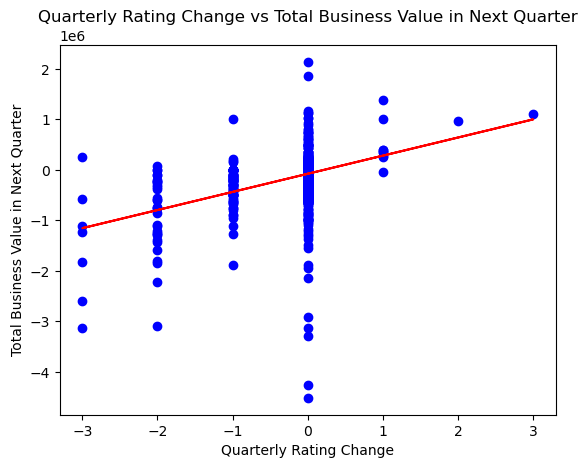

In [68]:
plt.scatter(X, y, color='blue')
plt.plot(X, lr_model.predict(X), color='red')
plt.title('Quarterly Rating Change vs Total Business Value in Next Quarter')
plt.xlabel('Quarterly Rating Change')
plt.ylabel('Total Business Value in Next Quarter')
plt.show()

Obsevations:
1. The regression best fit line in a linear regression model, indicates that there is a negative trend from 0 "change in rating" towards negative "change in rating". As the change in rating is decreasing, the change in total business values also decreases.
2. Similarly, the regression best fit line in a linear regression model, indicates that there is a positive trend from 0 "change in rating" towards postive "change in rating". As the change in rating is increasing, the change in total business values also increasing.

Insight:
1. The regression best fit line in a linear regression model, indicates that there is a negative trend from 0 "change in rating" towards negative "change in rating". As the change in rating is decreasing, the change in total business values also decreases.
2. 
Similarly, the regression best fit line in a linear regression model, indicates that there is a positive trend from 0 "change in rating" towards postive "change in rating". As the change in rating is increasing, the change in total business values also increasing
3. .The t-test of independence confirmed that the average change in total business values for drivers with negative change in quarterly rating is lesser than the average change in total business values for drivers with positve change in quarterly rating
4.  Whenever there is a negative change in drivers' rating, we can see there is a negative change in the Total Business Value also. The medians of the 'change in total business value' for the negatively changing quarterly ratings are lesser than the medians of the change in total business value for the positively changing quarterly ratings
5.  The barplot shows that the average change in total business value see to be in negative (total business value reduces) whenever there is a negative change in the drivers' quarterly rating.

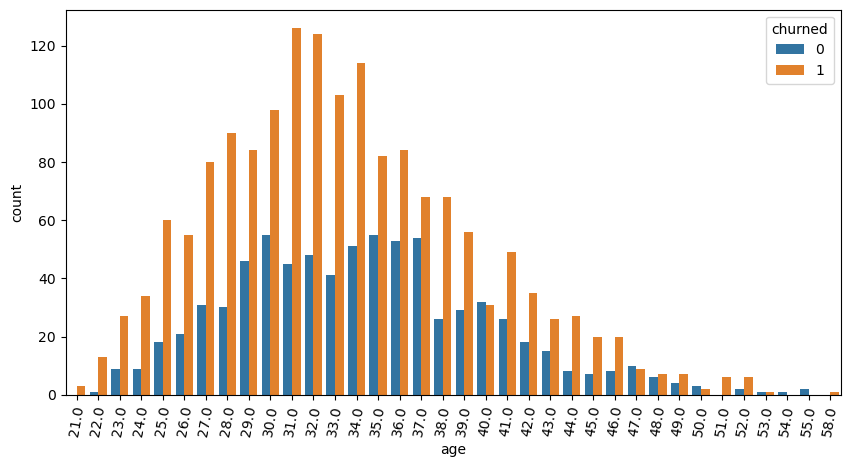

In [74]:
analyze_cat_variable(grp_data, 'age', hue = 'churned', plot_size = (10,5), xtick_rotate = 80)

Observations:
1. Most percent of the drivers in their 30s are have left the company with most number of drivers leaving who are in their 31 and 32 years. 

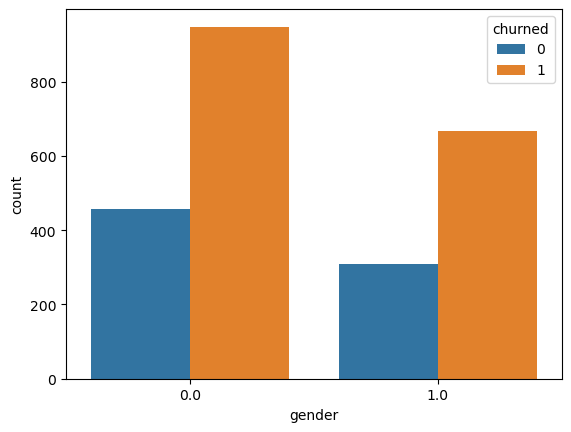

In [76]:
analyze_cat_variable(grp_data, 'gender', hue = 'churned')

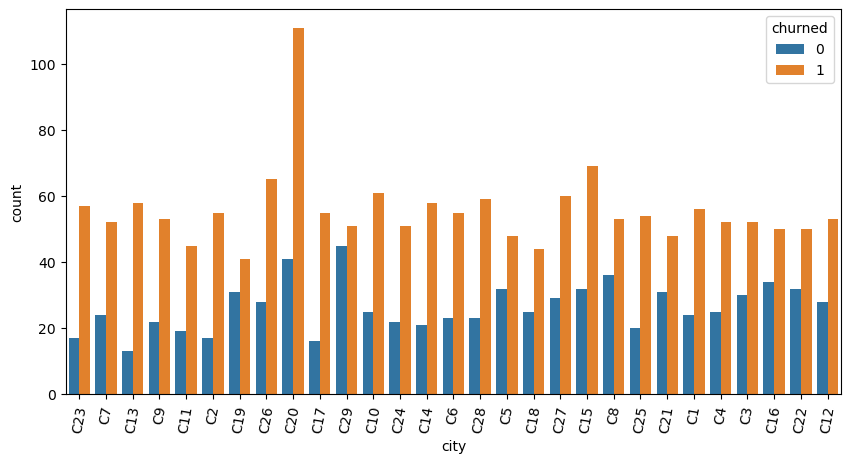

In [80]:
analyze_cat_variable(grp_data, 'city', hue = 'churned', plot_size = (10,5), xtick_rotate = 80)

Observations:
1. In the city of C20, the percent of drives left are the most among the other cities.
2. The city of C29, has the least percent of churn rate among the other cities.

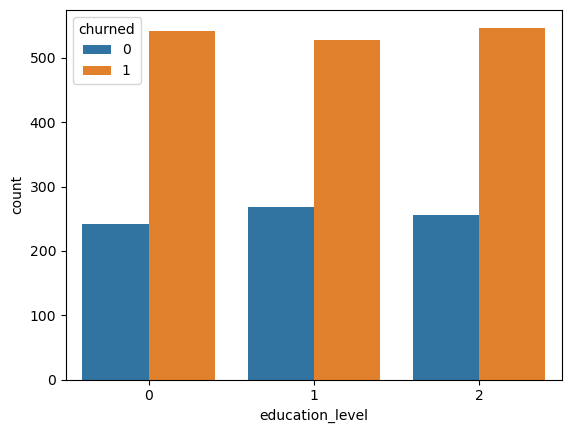

In [82]:
analyze_cat_variable(grp_data, 'education_level', hue = 'churned')

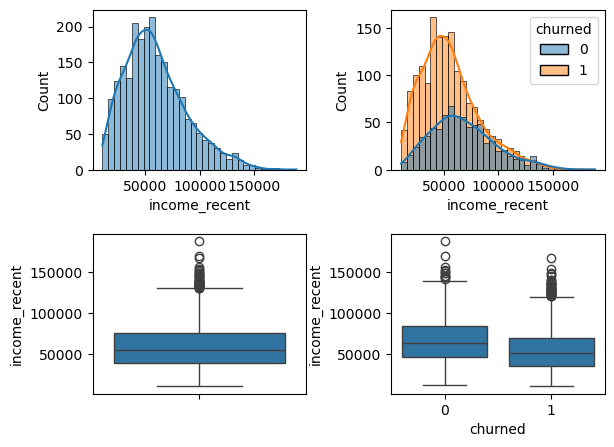

In [83]:
analyze_cont_variable_plts(grp_data, x = 'income_recent', hue = 'churned', kde = True)

Observations:
1. The median monthly income of the drivers that have left is lesser than the median monthly income of the drivers that are still with the company.

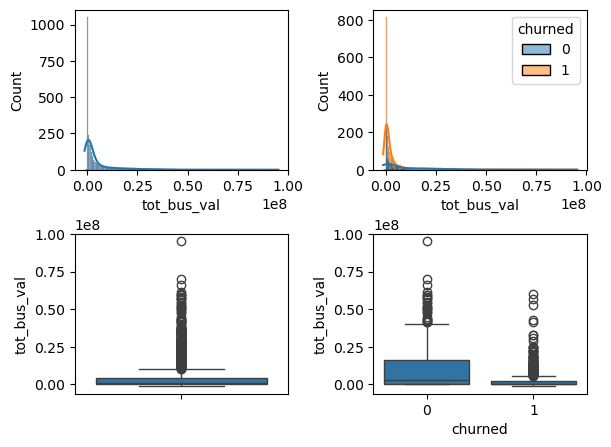

In [87]:
analyze_cont_variable_plts(grp_data, x = 'tot_bus_val', hue = 'churned', kde = True)

Observations:
1. The median Total Business Value generated by drivers that have left the company is lesser than the median Total Business Value generated by drivers that are still with the company.

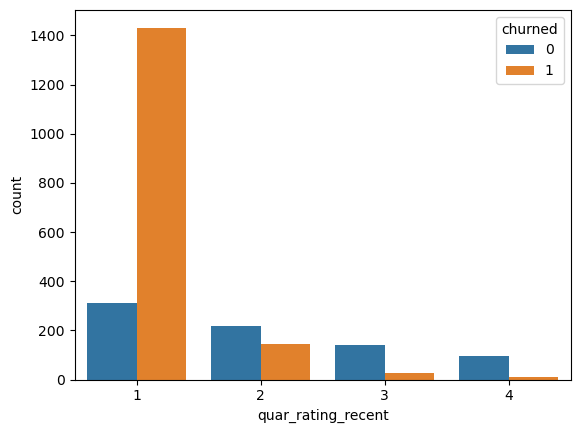

In [89]:
analyze_cat_variable(grp_data, 'quar_rating_recent', hue = 'churned')

Observations:
1. The drivers that have received a Quarterly Rating as 1 shows that the number of drivers left in this category is much larger than the number of drivers not left. Every other category in the quarterly rating shows that the number of drivers left the company is lesser than number of drivers not left.

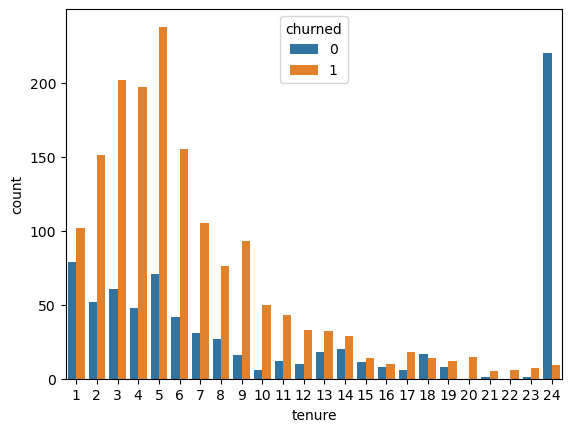

In [90]:
analyze_cat_variable(grp_data, 'tenure', hue = 'churned')

Observations:
1. Most of the drivers who left the company have tenure of between 2 months to 1 year with the company.

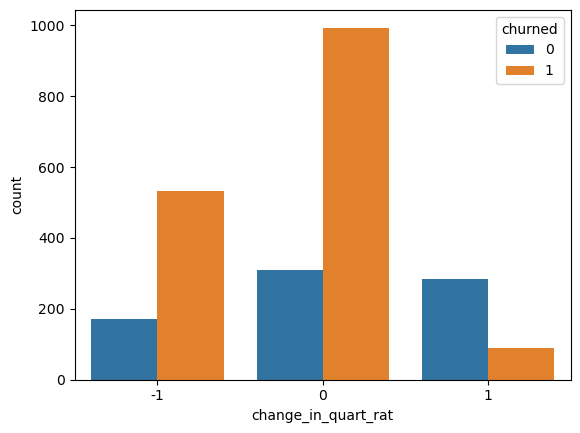

In [91]:
analyze_cat_variable(grp_data, 'change_in_quart_rat', hue = 'churned')

Observations:
1. Most of the drivers who either had no change in their Quarterly Rating or whose Quarterly Rating reduced are most likely to leave the company. Surprisingly, drivers that have no change in their Quarterly Rating are leaving more than drivers who have had a reduction in their Quarterly Rating. 
2. Drivers who received an increase in their Quarterly Rating are more likely to stay with the company.

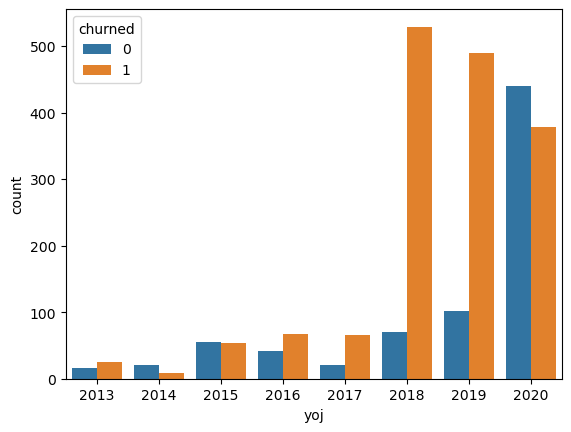

In [92]:
analyze_cat_variable(grp_data, 'yoj', hue = 'churned')

Observations:
1. Drivers who joined the company in 2018 and 2019 have the most churning rate among the others.

There are 17488 missing values in leaving_year.
There are 3 categories in leaving_year.


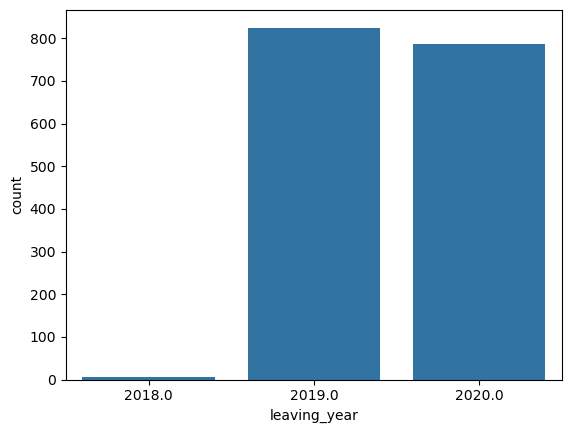

Percentage of data:
leaving_year
2019.0    4.318467
2020.0    4.114322
2018.0    0.026173
Name: count, dtype: float64


In [96]:
analyze_cat_variable(orig_data, 'leaving_year')

Observations:
1. In the given data, the churning happened in the years 2018, 2019 and 2020. Most of the drivers left the company in 2019 and the second most churning was in 2020.

There are 17488 missing values in leaving_month.
There are 12 categories in leaving_month.


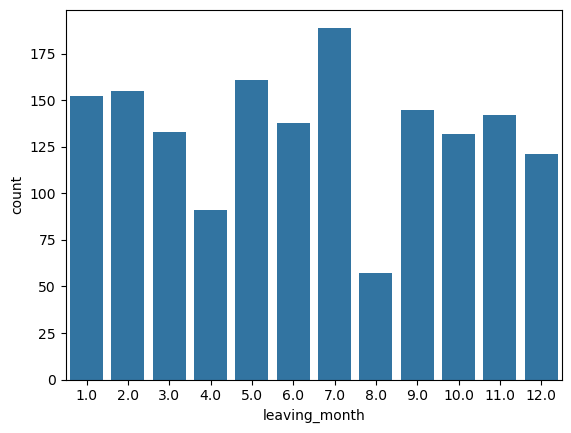

Top 5 categories in leaving_month:
leaving_month
7.0    0.989322
5.0    0.842755
2.0    0.811348
1.0    0.795645
9.0    0.759003
Name: count, dtype: float64
--------------------
Bottom 5 categories in leaving_month:
leaving_month
8.0     0.298367
4.0     0.476340
12.0    0.633375
10.0    0.690955
3.0     0.696189
Name: count, dtype: float64


In [97]:
analyze_cat_variable(orig_data, 'leaving_month')

Observations:
1. As per the data given, the churning rate is slightly more in the month of July and May than other months. And the churning rate is lowest in the month of august.

# Preparing for Model Building

### Encoding

In [98]:
#!pip install category_encoders

In [99]:
# spliting the independent and the target variables
x = grp_data.drop(['Driver_ID', 'tot_bus_val', 'churned'], axis = 1)
y = grp_data['churned']

# splitting dataset into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, stratify = y, random_state = 42)

In [100]:
y_train.value_counts()

churned
1    1083
0     512
Name: count, dtype: int64

In [101]:
y_test.value_counts()

churned
1    533
0    253
Name: count, dtype: int64

Observations:
1. There is an imbalance in the dataset between the drivers who left the company versus those who did not.

#### Target encoding

##### For the city variable since its cardinality is slightly high

In [102]:
# initializing the target encoder
target_encoder = TargetEncoder()

#fitting and transforming the data
x_train['city_encoded'] = target_encoder.fit_transform(x_train[['city']], y_train)
x_test['city_encoded'] = target_encoder.transform(x_test[['city']])

# dropping the city variable
x_train.drop(['city'], axis = 1, inplace = True)
x_test.drop(['city'], axis = 1, inplace = True)

#### One Hot encoding

##### The age_cat can be one hot encoded

In [103]:
onehot_encoder = OneHotEncoder(drop = 'first')

encoded_features = onehot_encoder.fit_transform(x_train[['age_cat']]).toarray()
encoded_df = pd.DataFrame(encoded_features, columns=onehot_encoder.get_feature_names_out(['age_cat']))
x_train = pd.concat([x_train.reset_index(), encoded_df], axis = 1)

encoded_features = onehot_encoder.transform(x_test[['age_cat']]).toarray()
encoded_df = pd.DataFrame(encoded_features, columns=onehot_encoder.get_feature_names_out(['age_cat']))
x_test = pd.concat([x_test.reset_index(), encoded_df], axis = 1)

In [104]:
# The age_cat and the age variables can be droped
x_train.drop(['age_cat'], axis = 1, inplace = True)
x_test.drop(['age_cat'], axis = 1, inplace = True)

x_train.drop(['age'], axis = 1, inplace = True)
x_test.drop(['age'], axis = 1, inplace = True)

In [105]:
x_train.isnull().sum()

index                  0
gender                 0
education_level        0
income_recent          0
income_avg             0
doj                    0
moj                    0
yoj                    0
j_desig                0
grade                  0
quar_rating_recent     0
quart_rating_avg       0
tenure                 0
change_in_quart_rat    0
change_in_income       0
neg_tot_bus_val        0
log_tot_bus_val        0
city_encoded           0
age_cat_senior         0
age_cat_young          0
dtype: int64

In [106]:
x_test.isnull().sum()

index                  0
gender                 0
education_level        0
income_recent          0
income_avg             0
doj                    0
moj                    0
yoj                    0
j_desig                0
grade                  0
quar_rating_recent     0
quart_rating_avg       0
tenure                 0
change_in_quart_rat    0
change_in_income       0
neg_tot_bus_val        0
log_tot_bus_val        0
city_encoded           0
age_cat_senior         0
age_cat_young          0
dtype: int64

Observations:
1. No missing values found in the train and test datasets.

### Scaling the data

#### Robust Scaling

##### Since there are outliers in the data, although its treating, using RobustScaler to handle outliers effectively

In [107]:
# initializing RobustScaler
rsc = RobustScaler()

# Fit and transform data
x_train_sc = rsc.fit_transform(x_train)
x_test_sc = rsc.transform(x_test)

In [108]:
#!pip install xgboost
#!pip3 install xgboost
#!pip install lightgbm[scikit-learn]

In [109]:
# Creating sample weights to balance the imbalance data in modeling
sample_weights = np.zeros(len(y_train))
sample_weights[y_train == 0] = 0.678997
sample_weights[y_train == 1] = 0.321003

sample_weights_test = np.zeros(len(y_test))
sample_weights_test[y_test == 0] = 0.678117
sample_weights_test[y_test == 1] = 0.321883

In [110]:
def evaluate(model, x, y, weights=None):
    """
    This function uses sklearn library functions to evaluate the performance of the models.
    This function measures the Precision, recall, f1_score and produces a confusion matrix and a classification report
    Input:
        model: The sklearn model to be evaluated.
        x: dependent features
        y: target values
        weights: default = None. If sample weights need to be used for the f1 score, confusion matrix and classification report.
    """
    print(f"Precision score : {metrics.precision_score(model.predict(x), y, average = 'weighted')}")
    print(f"Recall score : {metrics.recall_score(model.predict(x), y, average = 'weighted')}")
    print(f"F1 score : {metrics.f1_score(model.predict(x), y, average = 'weighted')}")
    tn, fp, fn, tp = metrics.confusion_matrix(model.predict(x), y, sample_weight = weights).ravel()
    print(f"True Positives: {tp}\tFalse Positives: {fp}")
    print(f"True Negatives: {tn}\tFalse Negatives: {fn}")
    print("Classification Report:")
    print(metrics.classification_report(y, model.predict(x), sample_weight = weights))

## Model Building

Thoughts:
1. The positive class in this study is a driver left the company. The objective is to predict if a driver will leave or not. Hence the focus should be on increasing the sensitivity of the model. I will use Recall as my primary metric while keeping precision in check.
2. Also it is important to make sure unnecessary actions are not taken on drivers who have less chance of leaving the company. Need to control the trade-off on precision score also.

#### RandomForest Baseline model

In [76]:
bag_basemodel = RandomForestClassifier(class_weight = 'balanced', random_state = 42)
bag_basemodel.fit(x_train_sc, y_train)
print("Base Bagging model:")
print(f"Train score: {bag_basemodel.score(x_train_sc, y_train)}")
print(f"Test score: {bag_basemodel.score(x_test_sc, y_test)}")

Base Bagging model:
Train score: 1.0
Test score: 0.9300254452926209


Observations:
1. The base RandomForest model is overfitting with the dataset. It requires hyperparameter tuning.

In [77]:
print("Training data:")
evaluate(bag_basemodel, x_train_sc, y_train)#, weights = sample_weights)

Training data:
Precision score : 1.0
Recall score : 1.0
F1 score : 1.0
True Positives: 1083	False Positives: 0
True Negatives: 512	False Negatives: 0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       512
           1       1.00      1.00      1.00      1083

    accuracy                           1.00      1595
   macro avg       1.00      1.00      1.00      1595
weighted avg       1.00      1.00      1.00      1595



In [78]:
print("Testing data:")
evaluate(bag_basemodel, x_test_sc, y_test)#, weights = sample_weights_test)

Testing data:
Precision score : 0.9336577901091027
Recall score : 0.9300254452926209
F1 score : 0.9309525645403508
True Positives: 517	False Positives: 16
True Negatives: 214	False Negatives: 39
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       253
           1       0.93      0.97      0.95       533

    accuracy                           0.93       786
   macro avg       0.93      0.91      0.92       786
weighted avg       0.93      0.93      0.93       786



Observations:
1. The randomforest baseline model is heavily overfitting.

#### GradientBoostingClassifier baseline model

In [79]:
# Gradient boosting classifier

boost_basemodel = GradientBoostingClassifier(random_state = 42)
boost_basemodel.fit(x_train_sc, y_train, sample_weight = sample_weights)


print("Base Boosting model:")
print(f"Train score: {boost_basemodel.score(x_train_sc, y_train)}")#, sample_weight = sample_weights)}")
print(f"Test score: {boost_basemodel.score(x_test_sc, y_test)}")#, sample_weight = sample_weights_test)}")

Base Boosting model:
Train score: 0.94858934169279
Test score: 0.9402035623409669


Observations:
1. The base GradientBoostingClassifier model is better than RandonForest model. However it is still overfitting with the dataset. It requires hyperparameter tuning.

In [80]:
print("Training data:")
evaluate(boost_basemodel, x_train_sc, y_train)#, weights = sample_weights)

Training data:
Precision score : 0.9495201200079889
Recall score : 0.94858934169279
F1 score : 0.9480000355774153
True Positives: 1017	False Positives: 66
True Negatives: 496	False Negatives: 16
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       512
           1       0.98      0.94      0.96      1083

    accuracy                           0.95      1595
   macro avg       0.93      0.95      0.94      1595
weighted avg       0.95      0.95      0.95      1595



In [81]:
print("Testing data:")
evaluate(boost_basemodel, x_test_sc, y_test)#, weights = sample_weights_test)

Testing data:
Precision score : 0.9399693261657271
Recall score : 0.9402035623409669
F1 score : 0.9398791650085019
True Positives: 504	False Positives: 29
True Negatives: 235	False Negatives: 18
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       253
           1       0.97      0.95      0.96       533

    accuracy                           0.94       786
   macro avg       0.93      0.94      0.93       786
weighted avg       0.94      0.94      0.94       786



Observations:
1. GBDT is able to reduce the False negatives pretty well. However there is a slight increase in the false positives.
2. However, the GBDT model is trying to generalize the data unlike the overfitting RandomForest model.

#### XGBoost baseline model

In [82]:
# initializing XGBoost classifier

xgboost_basemodel = xgboost.XGBClassifier(random_state = 42)
xgboost_basemodel.fit(x_train_sc, y_train, sample_weight = sample_weights)


print("Base Boosting model:")
print(f"Train score: {xgboost_basemodel.score(x_train_sc, y_train)}")#, sample_weight = sample_weights)}")
print(f"Test score: {xgboost_basemodel.score(x_test_sc, y_test)}")#, sample_weight = sample_weights_test)}")

Base Boosting model:
Train score: 0.9987460815047022
Test score: 0.9338422391857506


In [83]:
print("Training data:")
evaluate(xgboost_basemodel, x_train_sc, y_train)

Training data:
Precision score : 0.9987483971436594
Recall score : 0.9987460815047022
F1 score : 0.9987454388066952
True Positives: 1081	False Positives: 2
True Negatives: 512	False Negatives: 0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       512
           1       1.00      1.00      1.00      1083

    accuracy                           1.00      1595
   macro avg       1.00      1.00      1.00      1595
weighted avg       1.00      1.00      1.00      1595



In [84]:
print("Testing data:")
evaluate(xgboost_basemodel, x_test_sc, y_test)

Testing data:
Precision score : 0.9335300626615497
Recall score : 0.9338422391857506
F1 score : 0.9335775166575022
True Positives: 503	False Positives: 30
True Negatives: 231	False Negatives: 22
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       253
           1       0.96      0.94      0.95       533

    accuracy                           0.93       786
   macro avg       0.92      0.93      0.92       786
weighted avg       0.93      0.93      0.93       786



Observations:
1. The baseline XGBoost model is overfitting.

### LightGBM baseline model

In [85]:
#!pip install lightgbm

In [86]:
# initializing LGBMClassifier

lgbmboost_basemodel = lightgbm.LGBMClassifier(class_weight = 'balanced', random_state = 42)
lgbmboost_basemodel.fit(x_train_sc, y_train)


print("Base Boosting model:")
print(f"Train score: {lgbmboost_basemodel.score(x_train_sc, y_train)}")#, sample_weight = sample_weights)}")
print(f"Test score: {lgbmboost_basemodel.score(x_test_sc, y_test)}")#, sample_weight = sample_weights_test)}")

[LightGBM] [Info] Number of positive: 1083, number of negative: 512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1222
[LightGBM] [Info] Number of data points in the train set: 1595, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Base Boosting model:
Train score: 1.0
Test score: 0.9338422391857506


In [87]:
print("Training data:")
evaluate(lgbmboost_basemodel, x_train_sc, y_train)

Training data:
Precision score : 1.0
Recall score : 1.0
F1 score : 1.0
True Positives: 1083	False Positives: 0
True Negatives: 512	False Negatives: 0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       512
           1       1.00      1.00      1.00      1083

    accuracy                           1.00      1595
   macro avg       1.00      1.00      1.00      1595
weighted avg       1.00      1.00      1.00      1595



In [88]:
print("Testing data:")
evaluate(lgbmboost_basemodel, x_test_sc, y_test)

Testing data:
Precision score : 0.9336268253075908
Recall score : 0.9338422391857506
F1 score : 0.933707387873135
True Positives: 505	False Positives: 28
True Negatives: 229	False Negatives: 24
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       253
           1       0.95      0.95      0.95       533

    accuracy                           0.93       786
   macro avg       0.92      0.93      0.92       786
weighted avg       0.93      0.93      0.93       786



Observations:
1. LightGBM baseline model is heavily overfitting.

Observations:
1. Althogh the ensemble models are fitting well with the dataset, the models are overfitting. Hyperparameter tuning is required.

#### Oversampling - to balance the dataset
Using **SMOTE**

In [113]:
# Generate a synthetic data to balance out the dataset using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
x_train_sc_resampled, y_train_resampled = smote.fit_resample(x_train_sc, y_train)


In [114]:
y_train.value_counts()

churned
1    1083
0     512
Name: count, dtype: int64

In [115]:
y_train_resampled.value_counts()

churned
1    1083
0    1083
Name: count, dtype: int64

## Hyperparameter Tuning 

In [92]:
#pip install imblearn

In [93]:
#Balancing Dataset with SMOTE resampling

In [94]:
# Generate a synthetic dataset using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
x_train_sc_resampled, y_train_resampled = smote.fit_resample(x_train_sc, y_train)


In [95]:
y_train.value_counts()

churned
1    1083
0     512
Name: count, dtype: int64

In [96]:
y_train_resampled.value_counts()

churned
1    1083
0    1083
Name: count, dtype: int64

#### Hyperparameter tuning RandomForest model with oversampled data

##### Tuning with RandomizedSearchCV

In [97]:
# parameters to tune
params = {
    'n_estimators' : list(range(1,600,50)),
    'max_depth' : list(range(1,200,10)),
    'min_samples_split': list(range(2,10)),
    'min_samples_leaf' : list(range(1,10,2)),
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'bootstrap' : [True, False],
    'ccp_alpha' : uniform.rvs(loc=0, scale=0.4, size=10),#uniform(loc = 0, scale = 0.4),
    'max_features': range(2,x_train.shape[1]+1,1)
}

# initializing StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initializing RandomSearchCV
random = RandomizedSearchCV(
                            estimator = RandomForestClassifier(random_state = 42,
                                                              n_jobs = -1,
                                                              class_weight = 'balanced'),
                            param_distributions = params,
                            scoring = 'roc_auc',
                            cv = cv,
                            n_iter = 150,
                            n_jobs = -1
                            )

# performing hyperparameter tuning
random.fit(x_train_sc_resampled, y_train_resampled)
print(f"Best parameters: {random.best_params_}")
print(f"Best Scores: {random.best_score_}")

Best parameters: {'n_estimators': 401, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 10, 'max_depth': 41, 'criterion': 'entropy', 'ccp_alpha': 0.014747045537767534, 'bootstrap': True}
Best Scores: 0.9715053611205497


Observations:

**F1 weighted**
1. Best parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 11, 'max_depth': 80, 'criterion': 'entropy', 'ccp_alpha': 0.031164673899892747, 'bootstrap': False}
    - Best Scores: 0.9020504903002854
2. Best parameters: {'n_estimators': 150, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 12, 'max_depth': 170, 'criterion': 'entropy', 'ccp_alpha': 0.018935457065019225, 'bootstrap': True}
    - Best Scores: 0.9113115102226734
3. Best parameters: {'n_estimators': 450, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 12, 'max_depth': 180, 'criterion': 'entropy', 'ccp_alpha': 0.00563250041678618, 'bootstrap': False}
    - Best Scores: 0.9353599755818417
4. Best parameters: {'n_estimators': 340, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 18, 'max_depth': 10, 'criterion': 'log_loss', 'ccp_alpha': 0.03241508992088243, 'bootstrap': False}
    - Best Scores: 0.901545124093059

**ROC AUC**
1. Best parameters: {'n_estimators': 440, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 8, 'max_depth': 150, 'criterion': 'log_loss', 'ccp_alpha': 0.01895599347623769, 'bootstrap': False}
    - Best Scores: 0.9666147937352916
2. Best parameters: {'n_estimators': 490, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 7, 'max_depth': 170, 'criterion': 'log_loss', 'ccp_alpha': 0.11264970055321043, 'bootstrap': True}
    - Best Scores: 0.9362495831288304
3. Best parameters: {'n_estimators': 490, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 15, 'max_depth': 50, 'criterion': 'log_loss', 'ccp_alpha': 0.044475588207563414, 'bootstrap': True}
    - Best Scores: 0.9622052406211854
4. Best parameters: {'n_estimators': 590, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 13, 'max_depth': 20, 'criterion': 'entropy', 'ccp_alpha': 0.008051985918737037, 'bootstrap': True}
    - Best Scores: 0.9756632970891379
5. Best parameters: {'n_estimators': 201, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 12, 'max_depth': 31, 'criterion': 'entropy', 'ccp_alpha': 0.010621048172178016, 'bootstrap': True}
    - Best Scores: 0.9743937277406525

##### Further tuning with GridSearchCV

In [ ]:
# parameters for tunning
params_grid = {
    'n_estimators' : [201, 440, 490, 510],   
    'max_depth' : [20, 31, 50, 100, 150, 170],
    'criterion' : ['entropy','log_loss'],
    'bootstrap' : [True],
    'ccp_alpha' : [0.019, 0.11, 0.044, 0.008, 0.01],
    'max_features': [7,8,12,13,15]
}

# initializing StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# initializing GridSearchCV
grid = GridSearchCV(
                    estimator = RandomForestClassifier(random_state = 42,
                                                              n_jobs = -1,
                                                              class_weight = 'balanced'),
                    param_grid = params_grid,
                    scoring = 'roc_auc',
                    cv = cv,
                    n_jobs = -1
                    )

# Performing hyperparameter tuning
grid.fit(x_train_sc_resampled, y_train_resampled)

print(f"Best Params: {grid.best_params_}")
print(f"Best Scores: {grid.best_score_}")

Observations:
1. Best Params: {'bootstrap': True, 'ccp_alpha': 0.0056, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 11, 'n_estimators': 400}
    - Best Scores: 0.9330509034288764
2. Best Params: {'bootstrap': True, 'ccp_alpha': 0.008, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 13, 'n_estimators': 440}
    - Best Scores: 0.975515585873855
3. Best Params: {'bootstrap': True, 'ccp_alpha': 0.008, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 13, 'n_estimators': 440}
    - Best Scores: 0.975515585873855

##### Cross validation with cross_validate

In [99]:
# initializing RandomForestClassifier with the best hyperparameters
rf_model = RandomForestClassifier(bootstrap = True,
                               ccp_alpha = 0.008,
                               criterion = 'entropy',
                               max_depth = 20,
                               max_features = 13,
                               n_estimators = 440,
                               random_state = 42,
                               n_jobs = -1,
                               class_weight = 'balanced')

# initializing StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# initializing cross_validate
cv_acc_results = cross_validate(rf_model, x_train_sc_resampled, y_train_resampled, cv = cv, 
                               scoring = 'balanced_accuracy',
                               n_jobs = -1,
                               return_train_score = True)

print(f"KFold CV accuracy mean: \nTrain: {cv_acc_results['train_score'].mean()*100}\nValidation: {cv_acc_results['test_score'].mean()*100}")
print(f"KFold CV accuracy std: \nTrain: {cv_acc_results['train_score'].std()*100}\nValidation: {cv_acc_results['test_score'].std()*100}")

KFold CV accuracy mean: 
Train: 94.8291782086796
Validation: 92.33610341643583
KFold CV accuracy std: 
Train: 0.4392035454857003
Validation: 0.7357976662285026


##### creating the tuned RandomForestClassifier

In [117]:
# final RandomForestClassifier model with best hyperparameters
rf_model_resampled_data = RandomForestClassifier(bootstrap = True,
                               ccp_alpha = 0.008,
                               criterion = 'entropy',
                               max_depth = 20,
                               max_features = 13,
                               n_estimators = 440,
                               random_state = 42,
                               n_jobs = -1,
                               class_weight = 'balanced')

# training the model
rf_model_resampled_data.fit(x_train_sc_resampled, y_train_resampled)

RandomForestClassifier(ccp_alpha=0.008, class_weight='balanced',
                       criterion='entropy', max_depth=20, max_features=13,
                       n_estimators=440, n_jobs=-1, random_state=42)

##### Evaluating the model

In [132]:
evaluate(rf_model_resampled_data, x_train_sc_resampled, y_train_resampled)

Precision score : 0.9409662806966388
Recall score : 0.9409048938134811
F1 score : 0.9409067077013449
True Positives: 1013	False Positives: 70
True Negatives: 1025	False Negatives: 58
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1083
           1       0.95      0.94      0.94      1083

    accuracy                           0.94      2166
   macro avg       0.94      0.94      0.94      2166
weighted avg       0.94      0.94      0.94      2166



In [133]:
evaluate(rf_model_resampled_data, x_test_sc, y_test)

Precision score : 0.94042317467637
Recall score : 0.9402035623409669
F1 score : 0.9402979765397267
True Positives: 511	False Positives: 22
True Negatives: 228	False Negatives: 25
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       253
           1       0.95      0.96      0.96       533

    accuracy                           0.94       786
   macro avg       0.93      0.93      0.93       786
weighted avg       0.94      0.94      0.94       786



Observations:
1. Tuned RandomForestClassifier model.
2. The model is able to generalize the data very well.
3. The train Precision score : 0.9409662806966388, test precision score: 0.94042317467637.
4. The train Recall score : 0.9409048938134811, test Recall score : 0.9402035623409669.
5. The train F1 score : 0.9409067077013449, test F1 score : 0.9402979765397267.
6. The confusion matrix shows:
   - Train True Positives: 1013 | Test True Positives: 511
   - Train True Negatives: 1025 | Test True Negatives: 228
   - Train False Positives: 70 | Test False Positives: 22
   - Train False Negatives: 58 | Test False Negatives: 25

#### Hyperparameter tuning GradientBoostingClassifier model with oversampled data

##### Tuning with RandomizedSearchCV

In [ ]:
# hyperparameter tuning 5 times to see the tuned parameters.
for i in range(5):
    # parameters to tune
    params = {
        'loss' : ['exponential', 'log_loss'],
        'learning_rate' : np.arange(0, 1000,5, dtype=np.int64),
        'n_estimators' : np.arange(0, 1000,5, dtype=np.int64),
        'criterion': ['friedman_mse','squared_error'],
        'max_depth' : np.arange(10, 200,10, dtype=np.int64),
        'ccp_alpha' : uniform.rvs(loc=0, scale=0.4, size=10),
        'max_features': range(2,x_train.shape[1]+1,1)
    }
    # initialize StratifiedKFold
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    # initialize RandomSearchCV
    random = RandomizedSearchCV(
                                estimator = GradientBoostingClassifier(random_state = 42),
                                param_distributions = params,
                                scoring = 'roc_auc',
                                cv = cv,
                                n_iter = 150,
                                n_jobs = -1
                                )
    # training the model
    random.fit(x_train_sc_resampled, y_train_resampled)
    print(f"Best parameters: {random.best_params_}")
    print(f"Best Scores: {random.best_score_}")

Observations:

The following are the results from the RandomSearchCV

1. Best parameters: {'n_estimators': 230, 'max_features': 3, 'max_depth': 110, 'loss': 'exponential', 'learning_rate': 645, 'criterion': 'squared_error', 'ccp_alpha': 0.14934932821080316}
    - Best Scores: 0.95641242244623
2. Best parameters: {'n_estimators': 100, 'max_features': 10, 'max_depth': 80, 'loss': 'exponential', 'learning_rate': 775, 'criterion': 'friedman_mse', 'ccp_alpha': 0.24664926859210368}
     - Best Scores: 0.9615539066356663
3. Best parameters: {'n_estimators': 480, 'max_features': 4, 'max_depth': 160, 'loss': 'exponential', 'learning_rate': 695, 'criterion': 'squared_error', 'ccp_alpha': 0.20294155637933398}
    - Best Scores: 0.955060964848336
4. Best parameters: {'n_estimators': 360, 'max_features': 15, 'max_depth': 140, 'loss': 'exponential', 'learning_rate': 575, 'criterion': 'squared_error', 'ccp_alpha': 0.17722569787231357}
    - Best Scores: 0.9494939418819683
5. Best parameters: {'n_estimators': 110, 'max_features': 10, 'max_depth': 110, 'loss': 'exponential', 'learning_rate': 615, 'criterion': 'friedman_mse', 'ccp_alpha': 0.2464112042769001}
    - Best Scores: 0.9458493002856747

##### Further tuning with GridSearchCV

In [ ]:
# parameters to tune
params_grid = {
        'loss' : ['exponential'],
        'learning_rate' :[7,2,20,100,775],
        'n_estimators' : [100,110,230,360,480],
        'criterion': ['friedman_mse'],
        'max_depth' : [100,110,120],
        'ccp_alpha' : [0.1,0.13,0.15,0.17],
        'max_features': [2,3,4,5]
}

# initializing StratifierKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# initializing GridSearchCV
grid = GridSearchCV(
                    estimator = GradientBoostingClassifier(random_state = 42),
                    param_grid = params_grid,
                    scoring = 'f1_weighted',
                    cv = cv,
                    n_jobs = -1
                    )

# performing the tuning
grid.fit(x_train_sc_resampled, y_train_resampled)

print(f"Best Params: {grid.best_params_}")
print(f"Best Scores: {grid.best_score_}")

##### Cross validating GradientBoostingClassifier with tuned hyperparameters

In [ ]:
# initializing GradientBoostingClassifier with the best hyperparameters
gbc_model = GradientBoostingClassifier(
                               ccp_alpha = 0.1,
                               criterion = 'friedman_mse',
                                learning_rate = 2,
                                loss ='exponential',
                               max_depth = 100,
                               max_features = 4,
                               n_estimators = 100,
                               random_state = 42)

# initializing StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

#  initializating cross_validate
cv_acc_results = cross_validate(gbc_model, x_train_sc_resampled, y_train_resampled, cv = cv, 
                               scoring = 'balanced_accuracy',
                               n_jobs = -1,
                               return_train_score = True)

print(f"KFold CV accuracy mean: \nTrain: {cv_acc_results['train_score'].mean()*100}\nValidation: {cv_acc_results['test_score'].mean()*100}")
print(f"KFold CV accuracy std: \nTrain: {cv_acc_results['train_score'].std()*100}\nValidation: {cv_acc_results['test_score'].std()*100}")

##### Creating GradientBoostingClassifier with best hyperparameters

In [118]:
# initializing GradientBoostingClassifier with best hyperparameters
gbc_model = GradientBoostingClassifier(
                               ccp_alpha = 0.1,
                               criterion = 'friedman_mse',
                                learning_rate = 2,
                                loss ='exponential',
                               max_depth = 100,
                               max_features = 4,
                               n_estimators = 100,
                               random_state = 42)

# training the model
gbc_model.fit(x_train_sc_resampled, y_train_resampled)

GradientBoostingClassifier(ccp_alpha=0.1, learning_rate=2, loss='exponential',
                           max_depth=100, max_features=4, random_state=42)

In [129]:
evaluate(gbc_model,x_train_sc_resampled, y_train_resampled)

Precision score : 0.8874923372970502
Recall score : 0.8864265927977839
F1 score : 0.8864871451814633
True Positives: 985	False Positives: 98
True Negatives: 935	False Negatives: 148
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1083
           1       0.87      0.91      0.89      1083

    accuracy                           0.89      2166
   macro avg       0.89      0.89      0.89      2166
weighted avg       0.89      0.89      0.89      2166



In [130]:
evaluate(gbc_model,x_test_sc, y_test)

Precision score : 0.8834970571267754
Recall score : 0.8829516539440203
F1 score : 0.8831992000607117
True Positives: 489	False Positives: 44
True Negatives: 205	False Negatives: 48
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       253
           1       0.91      0.92      0.91       533

    accuracy                           0.88       786
   macro avg       0.87      0.86      0.87       786
weighted avg       0.88      0.88      0.88       786



Observations:
1. Tuned GradientBoostingClassifier model.
2. The model is doing a decent job at predictions but not as well as the RandomForestClassifier model. It is able to generalize the data.
3. The train Precision score : 0.8874923372970502, test precision score: 0.8834970571267754.
4. The train Recall score : 0.8864265927977839, test Recall score : 0.8829516539440203.
5. The train F1 score : 0.8864871451814633, test F1 score : 0.8831992000607117.
6. The confusion matrix shows:
    - Train True Positives: 985 | Test True Positives: 489.
    - Train True Negatives: 935 | Test True Negatives: 205.
    - Train False Positives: 98 | Test False Positives: 44.
    - Train False Negatives: 148 | Test False Negatives: 48.

#### Hyperparameter tuning XGBoost model with oversampled data

##### Tuning with RandomSearchCV

In [132]:
# parameters for tuning
params = {
    'n_estimators' : list(range(5,500,50)),
    'max_depth' : list(range(1,200,2)),
    'grow_policy': ['depthwise'],
    'learning_rate' : [0.01 , 0.03, 0.07,  0.08, 0.09, 0.1],
    'booster' : ['gbtree', 'dart'],
    'reg_alpha' : [0.0099, 0.001, 0.0012,0.9,1],
    'reg_lambda' : [0.4,0.5,0.6, 1],
    }

# initializing StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# initializing RandomSearchCV
random = RandomizedSearchCV(
                            estimator = xgboost.XGBClassifier(random_state = 42,
                                                              n_jobs = -1,
                                                              class_weight = 'balanced'),
                            param_distributions = params,
                            scoring = 'roc_auc',
                            cv = cv,
                            n_iter = 150,
                            n_jobs = -1
                            )

# performing hyperparameter tuning
random.fit(x_train_sc_resampled, y_train_resampled)
print(f"Best parameters: {random.best_params_}")
print(f"Best Scores: {random.best_score_}")

Best parameters: {'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 255, 'max_depth': 93, 'learning_rate': 0.1, 'grow_policy': 'depthwise', 'booster': 'gbtree'}
Best Scores: 0.9840356432715419


Observations:

1. Best parameters: {'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 355, 'max_depth': 20, 'learning_rate': 0.05, 'grow_policy': 'depthwise', 'booster': 'gbtree'} - 
Best Scores: 0.983914671977448
2. Best parameters: {'reg_lambda': 0.5, 'reg_alpha': 0.001, 'n_estimators': 205, 'max_depth': 20, 'learning_rate': 0.08, 'grow_policy': 'depthwise', 'booster': 'dart'} - 
Best Scores: 0.983690269440354
3. Best parameters: {'reg_lambda': 0.5, 'reg_alpha': 0.001, 'n_estimators': 305, 'max_depth': 40, 'learning_rate': 0.08, 'grow_policy': 'depthwise', 'booster': 'gbtree'} - 
Best Scores: 0.983842388089754
4. Best parameters: {'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 255, 'max_depth': 93, 'learning_rate': 0.1, 'grow_policy': 'depthwise', 'booster': 'gbtree'} - 
Best Scores: 0.9840356432715419831

##### Further tuning with GridSearchCV

In [160]:
# parameters to tune
params_grid = {
    'n_estimators' : [140,150,160],
    'max_depth' : [4,5,6],
    'grow_policy': ['depthwise'],
    'learning_rate' : [0.1],
    'booster' : ['gbtree'],
    'reg_alpha' : [0.0011, 0.0012,0.0013],
    'reg_lambda' : [0.4,0.5,0.6]}

# initializing StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#initializing GridSearchCV
grid = GridSearchCV(
                    estimator = xgboost.XGBClassifier(random_state = 42,
                                                              n_jobs = -1,
                                                              class_weight = 'balanced'),
                    param_grid = params_grid,
                    scoring = 'roc_auc',
                    cv = cv,
                    n_jobs = -1
                    )

# performing hyperparameter tuning
grid.fit(x_train_sc_resampled, y_train_resampled)

print(f"Best Params: {grid.best_params_}")
print(f"Best Scores: {grid.best_score_}")

Best Params: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'reg_alpha': 0.0012, 'reg_lambda': 0.5}
Best Scores: 0.9819852753218296


1. Best Params: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 255, 'reg_alpha': 1, 'reg_lambda': 0.5}
Best Scores: 0.981773678369486
2. Best Params: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'learning_rate': 0.1, 'max_depth': 18, 'n_estimators': 250, 'reg_alpha': 1, 'reg_lambda': 0.5}
Best Scores: 0.981773678369486
44. Best Params: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'learning_rate': 0.1, 'max_depth': 16, 'n_estimators': 245, 'reg_alpha': 1, 'reg_lambda': 0.5}
Best Scores: 0.981773678369486
5. Best Params: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'learning_rate': 0.1, 'max_depth': 14, 'n_estimators': 210, 'reg_alpha': 1, 'reg_lambda': 0.5}
Best Scores: 0.981807813887492
5. Best Params: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'reg_alpha': 0.0012, 'reg_lambda': 0.5}
Best Scores: 0.981985275321829674
4

##### Cross validating XGBoost model with tuned hyperparameters

In [161]:
# initializing XGBClassifier with best hyperparameter values
xgb_model = xgboost.XGBClassifier(n_estimators = 150,
                                  max_depth =  5,
                                  grow_policy = 'depthwise',
                                  learning_rate = 0.1,
                                  booster = 'gbtree',
                                  reg_alpha = 0.0012,
                                  reg_lambda = 0.5,
                                  random_state = 42,
                                  n_jobs = -1)
# initializing StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# performiing cross_validation
cv_acc_results = cross_validate(xgb_model, x_train_sc_resampled, 
                                y_train_resampled, cv = cv, 
                                scoring = 'roc_auc',
                                n_jobs = -1,
                                return_train_score = True)

print(f"KFold CV accuracy mean: \nTrain: {cv_acc_results['train_score'].mean()*100}\nValidation: {cv_acc_results['test_score'].mean()*100}")
print(f"KFold CV accuracy std: \nTrain: {cv_acc_results['train_score'].std()*100}\nValidation: {cv_acc_results['test_score'].std()*100}")

KFold CV accuracy mean: 
Train: 99.99950526442267
Validation: 98.35182510917306
KFold CV accuracy std: 
Train: 0.0005327343124244418
Validation: 0.719190452948719


##### XGBClassifier model with best hyperparameter values

In [119]:
# initializing xgboost classifier with best hyperparameter values
xgb_model = xgboost.XGBClassifier(n_estimators = 150,
                                  max_depth =  5,
                                  grow_policy = 'depthwise',
                                  learning_rate = 0.1,
                                  booster = 'gbtree',
                                  reg_alpha = 0.0012,
                                  reg_lambda = 0.5,
                                  random_state = 42,
                                  n_jobs = -1)

# training the model
xgb_model.fit(x_train_sc_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [135]:
evaluate(xgb_model,x_train_sc_resampled, y_train_resampled)

Precision score : 0.9990766389658357
Recall score : 0.9990766389658357
F1 score : 0.9990766389658357
True Positives: 1082	False Positives: 1
True Negatives: 1082	False Negatives: 1
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1083
           1       1.00      1.00      1.00      1083

    accuracy                           1.00      2166
   macro avg       1.00      1.00      1.00      2166
weighted avg       1.00      1.00      1.00      2166



In [136]:
evaluate(xgb_model,x_test_sc, y_test)

Precision score : 0.9414758269720102
Recall score : 0.9414758269720102
F1 score : 0.9414758269720102
True Positives: 510	False Positives: 23
True Negatives: 230	False Negatives: 23
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       253
           1       0.96      0.96      0.96       533

    accuracy                           0.94       786
   macro avg       0.93      0.93      0.93       786
weighted avg       0.94      0.94      0.94       786



Observations:
1. Tuned XGBClassifier model.
2. The model is overfitting with the training data.
3. The train Precision score : 0.9990766389658357, test precision score: 0.9414758269720102.
4. The train Recall score : 0.9990766389658357, test Recall score : 0.9414758269720102.
5. The train F1 score : 0.9990766389658357, test F1 score : 0.9414758269720102.
6. The confusion matrix shows:
   - Train True Positives: 1082 | Test True Positives: 510.
   - Train True Negatives: 1082 | Test True Negatives: 230.
   - Train False Positives: 1 | Test False Positives: 23.
   - Train False Negatives: 1 | Test False Negatives: 23

#### Hyperparameter tuning the LightGBM model with oversampled data

##### Tuning with RandomSearchCV

In [ ]:
# parameters to tune
params = {
    'num_leaves' : [5,10, 21, 31, 40,50],
    'n_estimators' : list(range(5,500,50)),
    'max_depth' : list(range(-1,200,5)),
    'subsample_for_bin' : np.int32([9e4, 1e5, 2e5, 5e5, 2e6]),
    'min_split_gain' : [0.03,0.02,0.01,0,0.1,0.2,0.3],
    'learning_rate' : [0.01 , 0.03, 0.07,  0.08, 0.09, 0.1],
    'boosting_type' : ['gbdt', 'dart', 'rf'],
    'reg_alpha' : [0.0001, 0.001, 0.5,0.9,1],
    'reg_lambda' : [0.4,0.5,0.6, 1],
    }

# initializing StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# initializing RandomizedSearchCV
random = RandomizedSearchCV(
                            estimator = lightgbm.LGBMClassifier(random_state = 42,
                                                              n_jobs = -1,
                                                              class_weight = 'balanced'),
                            param_distributions = params,
                            scoring = 'roc_auc',
                            cv = cv,
                            n_iter = 150,
                            n_jobs = -1
                            )
# performing hyperparameter tuning
random.fit(x_train_sc_resampled, y_train_resampled)
print(f"Best parameters: {random.best_params_}")
print(f"Best Scores: {random.best_score_}")

Observations:
1. Best parameters: {'subsample_for_bin': 100000, 'reg_lambda': 0.5, 'reg_alpha': 0.9, 'num_leaves': 10, 'n_estimators': 405, 'min_split_gain': 0, 'max_depth': 129, 'learning_rate': 0.07, 'boosting_type': 'gbdt'}
Best Scores: 0.985141374384918.
2. Best parameters: {'subsample_for_bin': 2000000, 'reg_lambda': 0.5, 'reg_alpha': 0.9, 'num_leaves': 10, 'n_estimators': 355, 'min_split_gain': 0.02, 'max_depth': 179, 'learning_rate': 0.07, 'boosting_type': 'gbdt'}
Best Scores: 0.984731582159801
3. Best parameters: {'subsample_for_bin': 100000, 'reg_lambda': 0.6, 'reg_alpha': 1, 'num_leaves': 21, 'n_estimators': 355, 'min_split_gain': 0.01, 'max_depth': 104, 'learning_rate': 0.09, 'boosting_type': 'gbdt'}
Best Scores: 0.984429232579504
4. Best parameters: {'subsample_for_bin': 2000000, 'reg_lambda': 0.4, 'reg_alpha': 0.9, 'num_leaves': 10, 'n_estimators': 305, 'min_split_gain': 0.01, 'max_depth': 64, 'learning_rate': 0.09, 'boosting_type': 'gbdt'}
Best Scores: 0.984628465536552
5. Best parameters: {'subsample_for_bin': 90000, 'reg_lambda': 1, 'reg_alpha': 1, 'num_leaves': 40, 'n_estimators': 105, 'min_split_gain': 0, 'max_depth': 139, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}
Best Scores: 0.98440382703464616562

#### Tuning with GridSearchCV

In [149]:
# parameters to tune
params_grid = {
    'num_leaves' : [10],
    'n_estimators' : [158],
    'max_depth' : [9],
    'subsample_for_bin' : [1470],
    'min_split_gain' : [0.02],
    'learning_rate' : [0.1],
    'boosting_type' : ['gbdt'],
    'reg_alpha' : [1],
    'reg_lambda' : [0.6]
}

# initializing StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# initializing GridSearchCV
grid = GridSearchCV(
                    estimator = lightgbm.LGBMClassifier(random_state = 42,
                                                              n_jobs = -1,
                                                              class_weight = 'balanced'),
                    param_grid = params_grid,
                    scoring = 'roc_auc',
                    cv = cv,
                    n_jobs = -1
                    )
# performing hyperparameter tuning
grid.fit(x_train_sc_resampled, y_train_resampled)

print(f"Best Params: {grid.best_params_}")
print(f"Best Scores: {grid.best_score_}")

[LightGBM] [Info] Number of positive: 1083, number of negative: 1083
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2472
[LightGBM] [Info] Number of data points in the train set: 2166, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best Params: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 9, 'min_split_gain': 0.02, 'n_estimators': 158, 'num_leaves': 10, 'reg_alpha': 1, 'reg_lambda': 0.6, 'subsample_for_bin': 1470}
Best Scores: 0.9820622411839484


Observations:
1. Best Params: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'min_split_gain': 0.02, 'n_estimators': 305, 'num_leaves': 10, 'reg_alpha': 1, 'reg_lambda': 0.6, 'subsample_for_bin': 90000}
Best Scores: 0.982031547742369
2.Best Params: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 64, 'min_split_gain': 0.02, 'n_estimators': 255, 'num_leaves': 10, 'reg_alpha': 1, 'reg_lambda': 0.6, 'subsample_for_bin': 50000}
Best Scores: 0.9820315477423
3. Best Params: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 50, 'min_split_gain': 0.02, 'n_estimators': 200, 'num_leaves': 10, 'reg_alpha': 1, 'reg_lambda': 0.6, 'subsample_for_bin': 10000}
Best Scores: 0.982031547742369
4. Best Params: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 40, 'min_split_gain': 0.02, 'n_estimators': 200, 'num_leaves': 10, 'reg_alpha': 1, 'reg_lambda': 0.6, 'subsample_for_bin': 10000}
Best Scores: 0.982031547742369
5. Best Params: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 10, 'min_split_gain': 0.02, 'n_estimators': 190, 'num_leaves': 10, 'reg_alpha': 1, 'reg_lambda': 0.6, 'subsample_for_bin': 9000}
Best Scores: 0.982031547742369
6. Best Params: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 9, 'min_split_gain': 0.02, 'n_estimators': 180, 'num_leaves': 10, 'reg_alpha': 1, 'reg_lambda': 0.6, 'subsample_for_bin': 8000}
Best Scores: 0.982031547742369
7. Best Params: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 9, 'min_split_gain': 0.02, 'n_estimators': 160, 'num_leaves': 10, 'reg_alpha': 1, 'reg_lambda': 0.6, 'subsample_for_bin': 3000}
Best Scores: 0.982044336676360
8. Best Params: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 9, 'min_split_gain': 0.02, 'n_estimators': 158, 'num_leaves': 10, 'reg_alpha': 1, 'reg_lambda': 0.6, 'subsample_for_bin': 1470}
Best Scores: 0.9820622411839484744446488871116

##### Cross validation with best hyperparameter values

In [151]:
# initializing LGBMClassifier with best hyperparameter values
lgbm_model = lightgbm.LGBMClassifier(boosting_type = 'gbdt',
                                     learning_rate = 0.1,
                                     max_depth = 9,
                                     min_split_gain = 0.02,
                                     n_estimators = 158,
                                     num_leaves = 10,
                                     reg_alpha = 1,
                                     reg_lambda = 0.6,
                                     subsample_for_bin = 1470,
                                     random_state = 42,
                                     n_jobs = -1,
                                     class_weight = 'balanced')

# initializing StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# performing cross validating
cv_acc_results = cross_validate(lgbm_model, x_train_sc_resampled, 
                                y_train_resampled, cv = cv, 
                                scoring = 'roc_auc',
                                n_jobs = -1,
                                return_train_score = True)

print(f"KFold CV accuracy mean: \nTrain: {cv_acc_results['train_score'].mean()*100}\nValidation: {cv_acc_results['test_score'].mean()*100}")
print(f"KFold CV accuracy std: \nTrain: {cv_acc_results['train_score'].std()*100}\nValidation: {cv_acc_results['test_score'].std()*100}")

KFold CV accuracy mean: 
Train: 99.917297303865
Validation: 98.50453367060572
KFold CV accuracy std: 
Train: 0.003951135087580624
Validation: 0.6645455316237634


##### Creating LGBMClassifier model with tuned hyperparameters

In [120]:
# lightgbm with tuned hyperparameters
lgbm_model = lightgbm.LGBMClassifier(boosting_type = 'gbdt',
                                     learning_rate = 0.1,
                                     max_depth = 9,
                                     min_split_gain = 0.02,
                                     n_estimators = 158,
                                     num_leaves = 10,
                                     reg_alpha = 1,
                                     reg_lambda = 0.6,
                                     subsample_for_bin = 1470,
                                     random_state = 42,
                                     n_jobs = -1,
                                     class_weight = 'balanced')

# training the model
lgbm_model.fit(x_train_sc_resampled, y_train_resampled)

[LightGBM] [Info] Number of positive: 1083, number of negative: 1083
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2472
[LightGBM] [Info] Number of data points in the train set: 2166, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(class_weight='balanced', max_depth=9, min_split_gain=0.02,
               n_estimators=158, n_jobs=-1, num_leaves=10, random_state=42,
               reg_alpha=1, reg_lambda=0.6, subsample_for_bin=1470)

In [138]:
evaluate(lgbm_model,x_train_sc_resampled, y_train_resampled)

Precision score : 0.9838518393471162
Recall score : 0.9838411819021238
F1 score : 0.98384126800844
True Positives: 1063	False Positives: 20
True Negatives: 1068	False Negatives: 15
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1083
           1       0.99      0.98      0.98      1083

    accuracy                           0.98      2166
   macro avg       0.98      0.98      0.98      2166
weighted avg       0.98      0.98      0.98      2166



In [139]:
evaluate(lgbm_model,x_test_sc, y_test)

Precision score : 0.936181921473301
Recall score : 0.9363867684478372
F1 score : 0.9362571037241681
True Positives: 506	False Positives: 27
True Negatives: 230	False Negatives: 23
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       253
           1       0.96      0.95      0.95       533

    accuracy                           0.94       786
   macro avg       0.93      0.93      0.93       786
weighted avg       0.94      0.94      0.94       786



Observations:
1. Tuned LGBMClassifier model.
2. The model is slightly overfitting. However, it is better than XGBoost model in terms of generalization.
3. The train Precision score : 0.9838518393471162, test precision score: 0.936181921473301.
4. The train Recall score : 0.9838411819021238, test Recall score : 0.9363867684478372.
5. The train F1 score : 0.98384126800844, test F1 score : 0.9362571037241681.
6. The confusion matrix shows:
   - Train True Positives: 1063 | Test True Positives: 506.
   - Train True Negatives: 1068 | Test True Negatives: 230.
   - Train False Positives: 20 | Test False Positives: 27.
   - Train False Negatives: 15 | Test False Negatives: 23

## Identifying threshold

#### ROC-AUC Scores

In [121]:
# Spliting the training dataset into train and evaluation sets
x_train_sc_res, x_eval_sc_res, y_train_res, y_eval_res = train_test_split(x_train_sc_resampled, y_train_resampled, 
                                                                          test_size = 0.33, stratify = y_train_resampled,
                                                                          random_state = 42)


#Training the models with new train dataset so that threshold can be found using evaluation dataset
# RandomForestClassifier with tuned hyperparameters
rf_model_resampled_data.fit(x_train_sc_res, y_train_res)
# GradientBoostClassifier with tuned hyperparameters 
gbc_model.fit(x_train_sc_res, y_train_res)
# XGBClassifier with tuned hyperparameters
xgb_model.fit(x_train_sc_res, y_train_res)
#LGBMClassifier with tuned hyperparameters
lgbm_model.fit(x_train_sc_res, y_train_res)

#predicting the probabilities
preds_rf = rf_model_resampled_data.predict_proba(x_eval_sc_res)[:,1]
preds_gbdt = gbc_model.predict_proba(x_eval_sc_res)[:,1]
preds_xgb = xgb_model.predict_proba(x_eval_sc_res)[:,1]
preds_lgbm = lgbm_model.predict_proba(x_eval_sc_res)[:,1]

#getting the False positive rates, true positive rates and thresholds from roc_curve()
# for random forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_eval_res, preds_rf)
auc_score_rf = roc_auc_score(y_eval_res, preds_rf)
# for gradient boost
fpr_gbdt, tpr_gbdt, thresholds_gbdt = roc_curve(y_eval_res, preds_gbdt)
auc_score_gbdt = roc_auc_score(y_eval_res, preds_gbdt)
# for xgboost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_eval_res, preds_xgb)
auc_score_xgb = roc_auc_score(y_eval_res, preds_xgb)
# for light gbm
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_eval_res, preds_lgbm)
auc_score_lgbm = roc_auc_score(y_eval_res, preds_lgbm)

[LightGBM] [Info] Number of positive: 726, number of negative: 725
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2394
[LightGBM] [Info] Number of data points in the train set: 1451, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


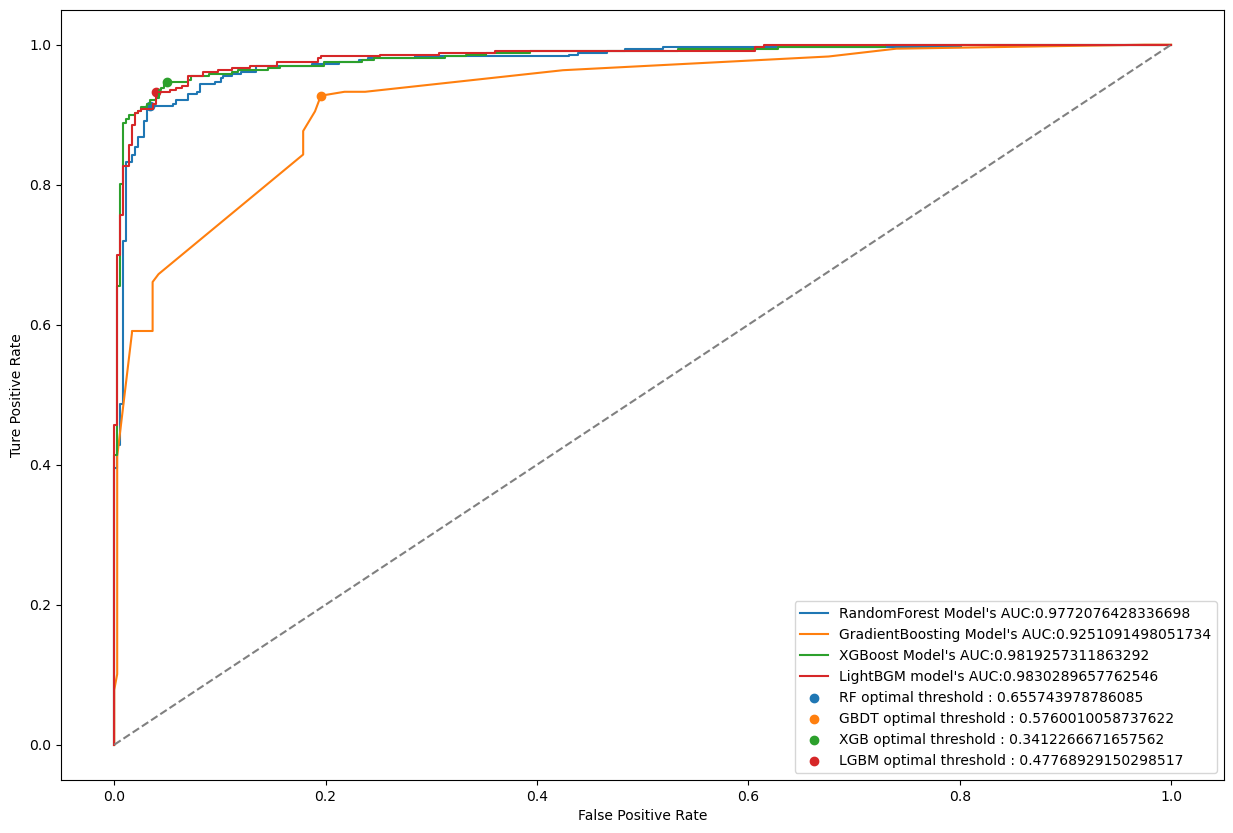

In [122]:
#plotting the tpr-fpr curve for the 4 models
plt.figure(figsize = (15,10))
plt.plot(fpr_rf, tpr_rf, label = f"RandomForest Model's AUC:{auc_score_rf}")
plt.plot(fpr_gbdt, tpr_gbdt, label = f"GradientBoosting Model's AUC:{auc_score_gbdt}")
plt.plot(fpr_xgb, tpr_xgb, label = f"XGBoost Model's AUC:{auc_score_xgb}")
plt.plot(fpr_lgbm, tpr_lgbm, label = f"LightBGM model's AUC:{auc_score_lgbm}")

#plotting the random model
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Find the threshold corresponding to the maximum distance
# for random forest
distance_to_top_left_rf = tpr_rf - fpr_rf
optimal_threshold_rf = thresholds_rf[np.argmax(distance_to_top_left_rf)]
# for gradient boost
distance_to_top_left_gbdt = tpr_gbdt - fpr_gbdt
optimal_threshold_gbdt = thresholds_gbdt[np.argmax(distance_to_top_left_gbdt)]
# for xgboost
distance_to_top_left_xgb = tpr_xgb - fpr_xgb
optimal_threshold_xgb = thresholds_xgb[np.argmax(distance_to_top_left_xgb)]
#for lightgbm
distance_to_top_left_lgbm = tpr_lgbm - fpr_lgbm
optimal_threshold_lgbm = thresholds_lgbm[np.argmax(distance_to_top_left_lgbm)]

#plotting the optimal thresholds
# for random forest
plt.scatter(x = fpr_rf[np.argmax(distance_to_top_left_rf)], y = tpr_rf[np.argmax(distance_to_top_left_rf)]
            , label = f"RF optimal threshold : {optimal_threshold_rf}")
# for gradient boost
plt.scatter(x = fpr_gbdt[np.argmax(distance_to_top_left_gbdt)], y = tpr_gbdt[np.argmax(distance_to_top_left_gbdt)]
            , label = f"GBDT optimal threshold : {optimal_threshold_gbdt}")
# for xgboost
plt.scatter(x = fpr_xgb[np.argmax(distance_to_top_left_xgb)], y = tpr_xgb[np.argmax(distance_to_top_left_xgb)]
            , label = f"XGB optimal threshold : {optimal_threshold_xgb}")
#for lightgbm
plt.scatter(x = fpr_lgbm[np.argmax(distance_to_top_left_lgbm)], y = tpr_lgbm[np.argmax(distance_to_top_left_lgbm)]
            , label = f"LGBM optimal threshold : {optimal_threshold_lgbm}")

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('Ture Positive Rate')
plt.show()

Observations:
1. All four tunned models (RandomForestClassifier, GradienBoostClassifier, XGBClassifier and LGBMClassifier) are giving really good ROC-AUC score.
2. While the best ROC-AUC score is given by the LGBMClassifier model at probability threshold of 0.47768929150298517 with area under the curve of 0.98302896577622546, the XGBoost model gives a slightly better True Positive rate than the LGBMClassifier at the optimal threshold with a slight increase in the False Positive rate.
3. The results are as follows:
   - Random forest model - rf_model_resampled_data: ROC-AUC : 0.978 | Threshold: 0.6557439787860849.
   - Gradient Boosting model - 
gbc_mode: ROC-AUC : 0.93 | Threshold: 0.5760010058737622.
   - XGBoost model - 
xgb_mod: ROC-AUC : 0.981 | Threshold: 0.3412266671657562.
   - Light GBM model - l
lgbm_mo: ROC-AUC : 0.983 | Threshold: 0.47768929150298517del

## Precision-Recall Curve

In [123]:
def pr_auc(y_test, prec, recal, thresholds, beta = 1):
    """
    This function calculates the f-beta score based on the precision, recall, the threshold and the actual labels passed.
    The function plots the precision and the recall curves and uses the f-beta score to identify the best threshold.
    The focus on precision-recall trade of is set by the beta parameter.
    Input:
        - y_test: the actual labels (target variable).
        - prec: precision scores
        - recal: recall scores
        - thresholds: thresholds for the probability
        - beta: Beta value for the f-beta score. default = 1.
                Less than 1 to give more weightage to precision score
                Greater than 1 to give more weightage to recall score
    """
    # calculating f-beta score using precision and recall for each threshold
    # beta > 1 gives more weight to recall, while beta < 1 favors precision
    fbscore = ((1+(beta**2)) * prec * recal) / (((beta**2) * prec) + recal)
    
    # locate the index of the largest f score
    max_fb_score_index = np.argmax(fbscore)
    
    #obtaining the best threshold
    best_threshold = thresholds[max_fb_score_index]
    print(f'Best Threshold = {best_threshold}, F beta-Score = {fbscore[max_fb_score_index]}')
    
    # plot the Precision-Recall curve for the model
    #mean model
    mean_model = np.mean(y_test)
    
    #plotting the mean model
    plt.plot([0,1], [mean_model, mean_model], linestyle='--', label='Mean Model')
    
    #plotting Precision and Recall curve
    plt.plot(recal, prec, marker='.', label='Logistic Regression')
    
    #marking the optimal Precision and Recall value
    plt.scatter(x = recal[max_fb_score_index], y = prec[max_fb_score_index], 
                marker='o', color='black', label='Best Precision-Recall Tradeoff')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    # show the plot
    plt.show()

In [124]:
def evaluate(y_pred, y_test, weights=None):
    """
    This function used the sklearn.metrics library to evaluate the performances of the model.
    Input:
        - y_pred: The predictions
        - y_test: the actual labels
        - weights: sample weights for classification report.
    """
    print(f"Precision score : {metrics.precision_score(y_pred, y_test, average = 'weighted')}")
    print(f"Recall score : {metrics.recall_score(y_pred, y_test, average = 'weighted')}")
    print(f"F1 score : {metrics.f1_score(y_pred, y_test, average = 'weighted')}")
    tn, fp, fn, tp = metrics.confusion_matrix(y_pred, y_test).ravel()
    print(f"True Positives: {tp}\tFalse Positives: {fp}")
    print(f"True Negatives: {tn}\tFalse Negatives: {fn}")
    print("Classification Report:")
    print(metrics.classification_report(y_test, y_pred, sample_weight = weights))

In [125]:
#Training the model with train dataset so that threshold can be found using evaluation dataset
x_train_sc_res, x_eval_sc_res, y_train_res, y_eval_res = train_test_split(x_train_sc_resampled, y_train_resampled, 
                                                                          test_size = 0.33, stratify = y_train_resampled,
                                                                          random_state = 42)


#Training the models with train dataset so that threshold can be found using evaluation dataset
rf_model_resampled_data.fit(x_train_sc_res, y_train_res)
gbc_model.fit(x_train_sc_res, y_train_res)
xgb_model.fit(x_train_sc_res, y_train_res)
lgbm_model.fit(x_train_sc_res, y_train_res)

prec_rf, recal_rf, thresholds_rf = metrics.precision_recall_curve(y_eval_res, rf_model_resampled_data.predict_proba(x_eval_sc_res)[:,1])
prec_gbdt, recal_gbdt, thresholds_gbdt = metrics.precision_recall_curve(y_eval_res, gbc_model.predict_proba(x_eval_sc_res)[:,1])
prec_xgb, recal_xgb, thresholds_xgb = metrics.precision_recall_curve(y_eval_res, xgb_model.predict_proba(x_eval_sc_res)[:,1])
prec_lgbm, recal_lgbm, thresholds_lgbm = metrics.precision_recall_curve(y_eval_res, lgbm_model.predict_proba(x_eval_sc_res)[:,1])

[LightGBM] [Info] Number of positive: 726, number of negative: 725
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2394
[LightGBM] [Info] Number of data points in the train set: 1451, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


##### getting the best thresholds for RandomForestClassifier 

With beta = 1
Best Threshold = 0.655743978786085, F beta-Score = 0.9381294964028777


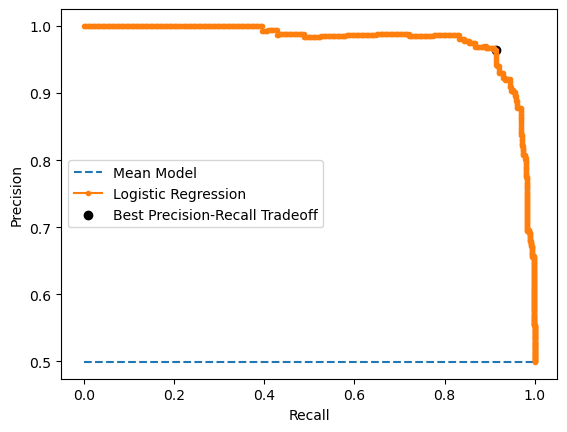

With beta = 0.5
Best Threshold = 0.6617806806347551, F beta-Score = 0.9553203997648441


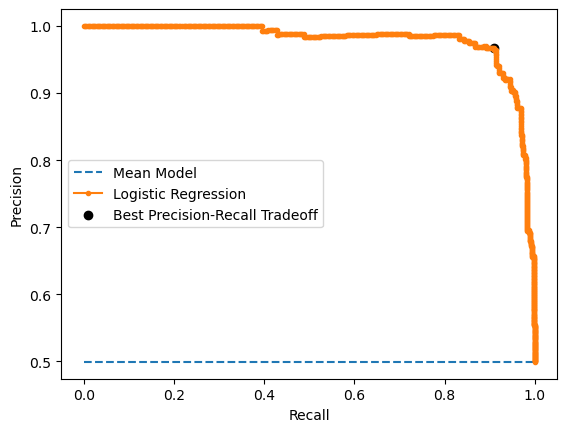

With beta = 2
Best Threshold = 0.24834026206573673, F beta-Score = 0.9495060373216246


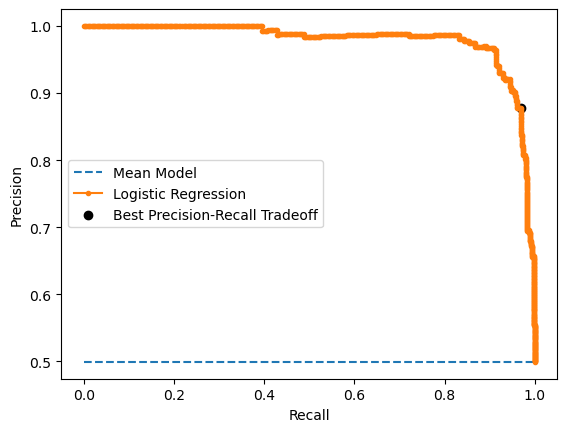

In [126]:
print("With beta = 1")
pr_auc(y_eval_res, prec_rf, recal_rf, thresholds_rf, beta = 1)

print("With beta = 0.5")
pr_auc(y_eval_res, prec_rf, recal_rf, thresholds_rf, beta = 0.5)

print("With beta = 2")
pr_auc(y_eval_res, prec_rf, recal_rf, thresholds_rf, beta = 2)

##### Evaluating Random Forest model with the optimal thresholds

In [127]:
threshs = [0.655743978786085, 0.661780680634755, 0.24834026206573676]
for thres in threshs:
    print(f"For threshold: {thres}")
    y_probas_rf = rf_model_resampled_data.predict_proba(x_eval_sc_res)[:,1]
    y_preds_rf = []
    for proba in y_probas_rf:
        if proba > thres:
            y_preds_rf.append(1)
        else:
            y_preds_rf.append(0)
    evaluate(y_preds_rf, y_eval_res)
    print("-"*80)

For threshold: 0.655743978786085
Precision score : 0.9400312252103248
Recall score : 0.9384615384615385
F1 score : 0.938512139408017
True Positives: 325	False Positives: 32
True Negatives: 346	False Negatives: 12
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       358
           1       0.96      0.91      0.94       357

    accuracy                           0.94       715
   macro avg       0.94      0.94      0.94       715
weighted avg       0.94      0.94      0.94       715

--------------------------------------------------------------------------------
For threshold: 0.661780680634755
Precision score : 0.9415903518105292
Recall score : 0.9398601398601398
F1 score : 0.9399145404572814
True Positives: 325	False Positives: 32
True Negatives: 347	False Negatives: 11
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       358
          

Observations:
1. The optimal threshold for the tuned RandomForestClassifier model that gives the best Recall score is 0.661780680634755. This model also gives the best precision score. The Recall score is 0.9398601398601398 and the precision  scoreis: 0.941590351810529. The 8
F1 scoise : 0.9399145404572. 14
True Positives: | 325	False Positives.  32
True Negatives |  347	False Negative.0.94       715

##### Getting the best thresholds for Gradient boosting model

With beta = 1
Best Threshold = 0.5760010058737622, F beta-Score = 0.8733509234828496


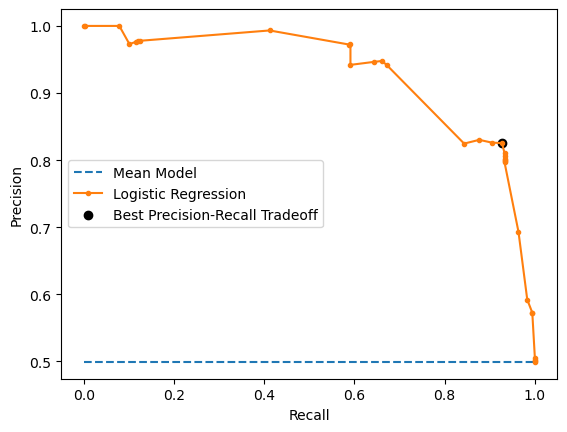

With beta = 0.5
Best Threshold = 0.9102337454713113, F beta-Score = 0.8721359940872138


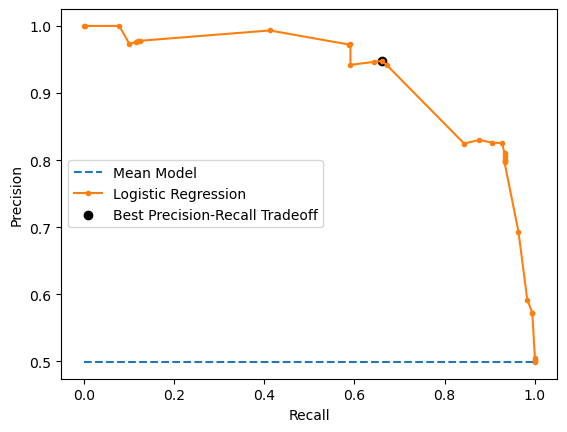

With beta = 2
Best Threshold = 0.30164900710187215, F beta-Score = 0.9053833605220228


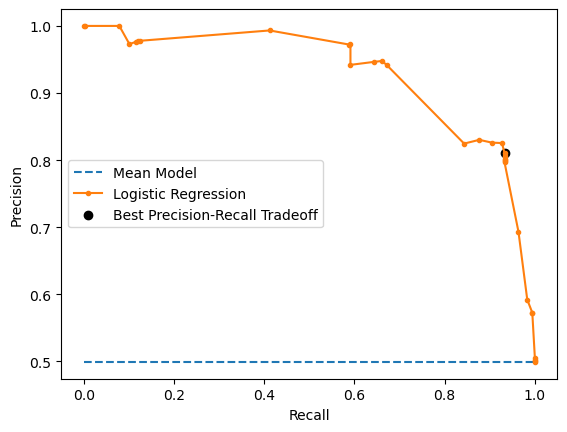

In [128]:
print("With beta = 1")
pr_auc(y_eval_res, prec_gbdt, recal_gbdt, thresholds_gbdt, beta = 1)

print("With beta = 0.5")
pr_auc(y_eval_res, prec_gbdt, recal_gbdt, thresholds_gbdt, beta = 0.5)

print("With beta = 2")
pr_auc(y_eval_res, prec_gbdt, recal_gbdt, thresholds_gbdt, beta = 2)

##### Evaluating the model with the thresholss

In [129]:
threshs = [0.5760010058737622, 0.9102337454713113, 0.30164900710187215]
for thres in threshs:
    print(f"For threshold: {thres}")
    y_probas_rf = gbc_model.predict_proba(x_eval_sc_res)[:,1]
    y_preds_rf = []
    for proba in y_probas_rf:
        if proba > thres:
            y_preds_rf.append(1)
        else:
            y_preds_rf.append(0)
    evaluate(y_preds_rf, y_eval_res)
    print("-"*80)

For threshold: 0.5760010058737622
Precision score : 0.8618461612875021
Recall score : 0.8573426573426574
F1 score : 0.8576564198265079
True Positives: 323	False Positives: 34
True Negatives: 290	False Negatives: 68
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       358
           1       0.83      0.90      0.86       357

    accuracy                           0.86       715
   macro avg       0.86      0.86      0.86       715
weighted avg       0.86      0.86      0.86       715

--------------------------------------------------------------------------------
For threshold: 0.9102337454713113
Precision score : 0.8551258140479305
Recall score : 0.8041958041958042
F1 score : 0.8093504086275171
True Positives: 230	False Positives: 127
True Negatives: 345	False Negatives: 13
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83       358
      

Observations:
1. The optimal threshold for the tuned GradientBoostingClassifier model that gives the best Recall score is 0.661780680634755. This model also gives the best precision score.
The Recall score is 0.9398601398601398 and the precision score is 0.9415903518105292.
The F1 score is 0.9399145404572814.
True Positives: 325 | False Positives: 32
True Negatives: 347 | False Negatives: 11

##### Getting the best threshold for tuned XGBoost model

With beta = 1
Best Threshold = 0.3412266671657562, F beta-Score = 0.9481065918653576


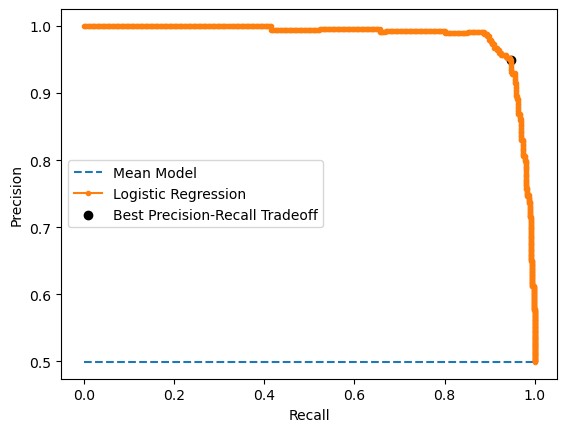

With beta = 0.5
Best Threshold = 0.7879171371459961, F beta-Score = 0.9682345754428834


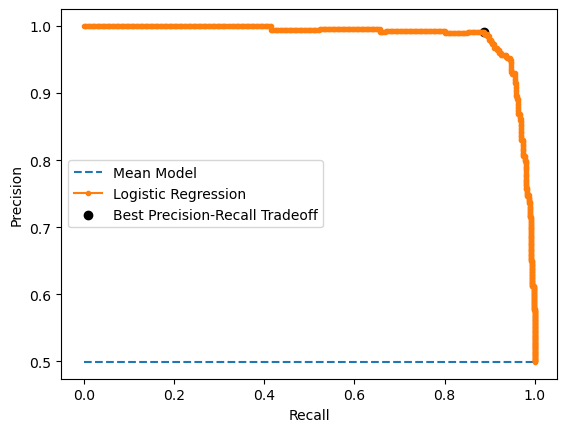

With beta = 2
Best Threshold = 0.20427115261554718, F beta-Score = 0.9498607242339834


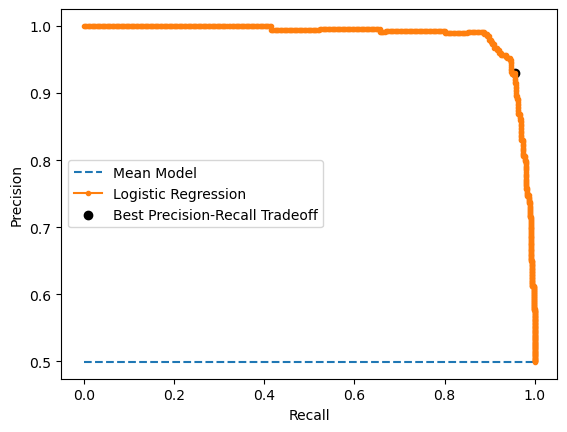

In [130]:
print("With beta = 1")
pr_auc(y_eval_res, prec_xgb, recal_xgb, thresholds_xgb, beta = 1)

print("With beta = 0.5")
pr_auc(y_eval_res, prec_xgb, recal_xgb, thresholds_xgb, beta = 0.5)

print("With beta = 2")
pr_auc(y_eval_res, prec_xgb, recal_xgb, thresholds_xgb, beta = 2)

##### Evaluating the model with the thresholds

In [131]:
threshs = [0.3412266671657562, 0.7879171371459961, 0.20427115261554718]
for thres in threshs:
    print(f"For threshold: {thres}")
    y_probas_rf = xgb_model.predict_proba(x_eval_sc_res)[:,1]
    y_preds_rf = []
    for proba in y_probas_rf:
        if proba > thres:
            y_preds_rf.append(1)
        else:
            y_preds_rf.append(0)
    evaluate(y_preds_rf, y_eval_res)
    print("-"*80)

For threshold: 0.3412266671657562
Precision score : 0.9468692114107821
Recall score : 0.9468531468531468
F1 score : 0.9468537706229797
True Positives: 337	False Positives: 20
True Negatives: 340	False Negatives: 18
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       358
           1       0.95      0.94      0.95       357

    accuracy                           0.95       715
   macro avg       0.95      0.95      0.95       715
weighted avg       0.95      0.95      0.95       715

--------------------------------------------------------------------------------
For threshold: 0.7879171371459961
Precision score : 0.944119873991711
Recall score : 0.9384615384615385
F1 score : 0.9386404658389969
True Positives: 316	False Positives: 41
True Negatives: 355	False Negatives: 3
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       358
         

Observations:
1. 
The optimal threshold for the tuneXGBClassifierer model that gives the best Recall score i0.341226667165756255. This model also gives the best precision scoreThe Recall score : 0.9468531468531468. 
The Precision score : 0.9468692114107821 
The F1 score : 0.94685377062297. 7
True Positives: 337 | False Positives:. 20
True Negatives: 340 | False Negatives.: 1811

##### Getting the best thresholds for LGBMClassifier model

With beta = 1
Best Threshold = 0.47768929150298517, F beta-Score = 0.9460227272727273


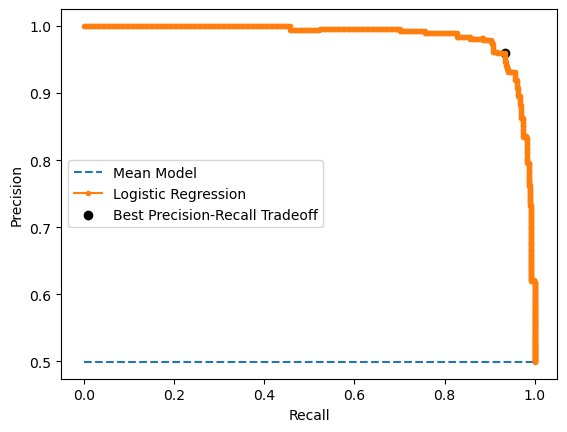

With beta = 0.5
Best Threshold = 0.6891766619976553, F beta-Score = 0.9623430962343097


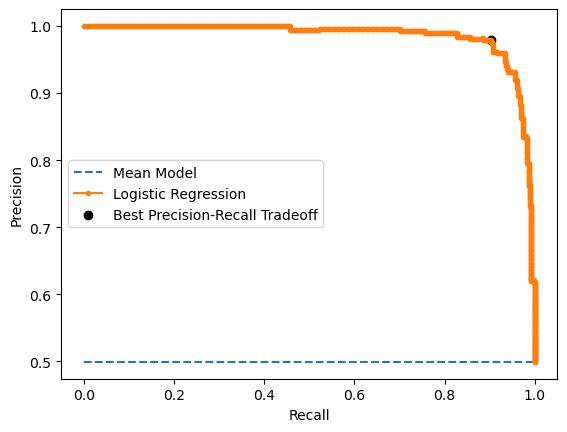

With beta = 2
Best Threshold = 0.2499402902729176, F beta-Score = 0.9522487506940589


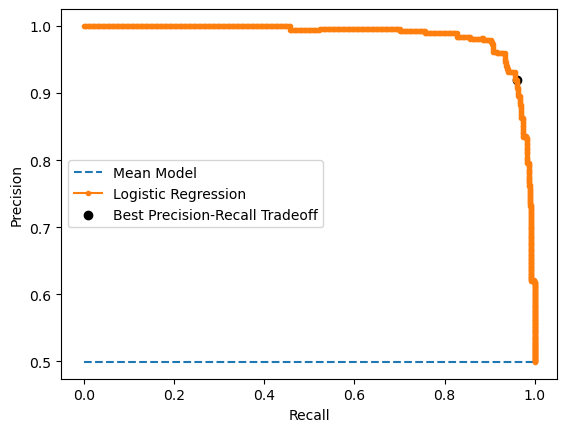

In [132]:
print("With beta = 1")
pr_auc(y_eval_res, prec_lgbm, recal_lgbm, thresholds_lgbm, beta = 1)

print("With beta = 0.5")
pr_auc(y_eval_res, prec_lgbm, recal_lgbm, thresholds_lgbm, beta = 0.5)

print("With beta = 2")
pr_auc(y_eval_res, prec_lgbm, recal_lgbm, thresholds_lgbm, beta = 2)

##### Evaluating the LGBMClassifier model for the thresholds

In [133]:
threshs = [0.47768929150298517, 0.6891766619976553, 0.2499402902729176]
for thres in threshs:
    print(f"For threshold: {thres}")
    y_probas_rf = lgbm_model.predict_proba(x_eval_sc_res)[:,1]
    y_preds_rf = []
    for proba in y_probas_rf:
        if proba > thres:
            y_preds_rf.append(1)
        else:
            y_preds_rf.append(0)
    evaluate(y_preds_rf, y_eval_res)
    print("-"*80)

For threshold: 0.47768929150298517
Precision score : 0.9459302664692084
Recall score : 0.9454545454545454
F1 score : 0.9454686332410217
True Positives: 332	False Positives: 25
True Negatives: 344	False Negatives: 14
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       358
           1       0.96      0.93      0.94       357

    accuracy                           0.95       715
   macro avg       0.95      0.95      0.95       715
weighted avg       0.95      0.95      0.95       715

--------------------------------------------------------------------------------
For threshold: 0.6891766619976553
Precision score : 0.9431571057926629
Recall score : 0.9398601398601398
F1 score : 0.9399626660509433
True Positives: 321	False Positives: 36
True Negatives: 351	False Negatives: 7
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       358
       

Observations:
1. The optimal threshold for the tuned LGBMClassifierer model that gives the best Recall score is 0.47768929150298517. This model also gives the best precision score. The Recall score : 0.9454545454545454. The Precision score : 0.9459302664692084. The F1 score : 0.9454686332410217. True Positives: 332 | False Positives:. 25 True Negatives: 344 | False Negatives.: 14

Observations:
1. For RandomForestClassifier:
   1. The best hyperparameter values are: RandomForestClassifier(bootstrap = True, ccp_alpha = 0.008, criterion = 'entropy', max_depth = 20, max_features = 13, n_estimators = 440, random_state = 42, n_jobs = -1, class_weight = 'balanced')
   2. The optimal threshold for the tuned RandomForestClassifier model that gives the best Recall score is 0.661780680634755. This model also gives the best precision score.
   3. The Recall score is 0.9398601398601398 and the precision score is 0.9415903518105292.
   4. The F1 score is 0.9399145404572814.
   5. True Positives: 325 | False Positives: 32
   6. True Negatives: 347 | False Negatives: 11
   7. Classification Report:
   -              precision    recall  f1-score   support

           0       0.92      0.97      0.94       358
           1       0.97      0.91      0.94       357
    -     accuracy                      0.94       715
    -     macroavg 0.94      0.94       0.94       715
    -     weighavg 0.94      0.94       0.94       715
2. For GradientBoostingClassifier:
    1. The best hyperparameter values are: GradientBoostingClassifier( ccp_alpha = 0.1, criterion = 'friedman_mse', learning_rate = 2, loss ='exponential', max_depth = 100, max_features = 4, n_estimators = 100, random_state = 42)
    2. The optimal threshold for the tuned GradientBoostingClassifier model that gives the best Recall score is 0.30164900710187215. This model also gives the best precision score.
    3. The Recall score : 0.8657342657342657 and the precision score : 0.8732851330945318.
    4. The F1 score : 0.8662329754678041.
    5. True Positives: 331 | False Positives: 26
    6. True Negatives: 288 | False Negatives: 70
    7. Classification Report:
    -     precision    recall  f1-score   support

           0       0.92      0.80      0.86       358
           1       0.83      0.93      0.87       357
    -     accuracy                     0.87       715
    -     macroavg 0.87      0.87      0.87       715
    -     weighavg 0.87      0.87      0.87       715
3. For XGBClassifier:
    1. The best hyperparameter values are: XGBClassifier(n_estimators = 150, max_depth = 5, grow_policy = 'depthwise', learning_rate = 0.1, booster = 'gbtree', reg_alpha = 0.0012, reg_lambda = 0.5, random_state = 42, n_jobs = -1)
    2. The optimal threshold for the tuned XGBClassifier model that gives the best Recall score is 0.3412266671657562. This model also gives the best precision score.
    3. The Recall score : 0.9468531468531468.
    4. The Precision score : 0.9468692114107821.
    5. The F1 score : 0.9468537706229797
    6. True Positives: 337 | False Positives: 20
    7. True Negatives: 340 | False Negatives: 18
    8. Classification Report:
    -     precision    recall  f1-score   support

          0        0.94      0.95      0.95       358
          1        0.95      0.94      0.95       357
    -     accuracy                     0.95       715
    -     macroavg 0.95      0.95      0.95       715
    -     weighavg 0.95      0.95      0.95       715
4. For LGBMClassifier:
    1. The best hyperparameter values are: LGBMClassifier(boosting_type = 'gbdt', learning_rate = 0.1, max_depth = 9, min_split_gain = 0.02, n_estimators = 158, num_leaves = 10, reg_alpha = 1, reg_lambda = 0.6, subsample_for_bin = 1470, random_state = 42, n_jobs = -1, class_weight = 'balanced').
    2. The optimal threshold for the tuned LGBMClassifier model that gives the best Recall score is 0.47768929150298517. This model also gives the best precision score.
    3. The Recall score : 0.9454545454545454.
    4. The Precision score : 0.9459302664692084.
    5. The F1 score : 0.9454686332410217
    6. True Positives: 332 | False Positives: 25
    7. True Negatives: 344 | False Negatives: 14
    8. Classification Report:
    -     precision    recall  f1-score   support

          0        0.93      0.96      0.95       358
          1        0.96      0.93      0.94       357
    -     accuracy                     0.95       715
    -     macroavg 0.95      0.95      0.95       715
    -     weighavg 0.95      0.95      0.95       715

## Feature Importance and Model interpretability

In [149]:
for col, imp in zip(x_train.columns.tolist()[1:],xgb_model.feature_importances_.tolist()[1:]):
    print(f"The {col} feature has {imp} importance.")

The gender feature has 0.011660218238830566 importance.
The education_level feature has 0.018344653770327568 importance.
The income_recent feature has 0.01856055110692978 importance.
The income_avg feature has 0.01331668347120285 importance.
The doj feature has 0.012476232834160328 importance.
The moj feature has 0.06941794604063034 importance.
The yoj feature has 0.18103204667568207 importance.
The j_desig feature has 0.026532817631959915 importance.
The grade feature has 0.00794390682131052 importance.
The quar_rating_recent feature has 0.5082557797431946 importance.
The quart_rating_avg feature has 0.023149382323026657 importance.
The tenure feature has 0.04462207108736038 importance.
The change_in_quart_rat feature has 0.012529043480753899 importance.
The change_in_income feature has 0.0 importance.
The neg_tot_bus_val feature has 0.0 importance.
The log_tot_bus_val feature has 0.01704329624772072 importance.
The city_encoded feature has 0.01278435904532671 importance.
The age_cat_

Observations:
1. The recent Quarterly Rating has the highest importance in predicting if the driver will leave or not. Followed by the year of joining, driver's average quarterly rating.
   

## Questionnaire:
1. What percentage of drivers have received a quarterly rating of 5?
    - **Answer**: The drivers in the dataset have received Quarterly rating between 1 to 4. There are no drivers who received a quarterly rating of 5
2. Comment on the correlation between Age and Quarterly Rating.
    - **Answer**: The boxplot shows an association between the Quarterly Rating and the age features. The rating 3 and 4 seem to be received more by slightly older drivers than ratings 1 and 2.
    - The Chi 2 contingency test confirms that there is an association between the age and the Quarterly Ratings features with a p value of 1.827140250113541e-12.
3. Name the city which showed the most improvement in Quarterly Rating over the past year.
    - **Answer**: The city that shows the most improvement in the Quarterly rating over the past year is C13. Followed by C23 and C7. 
    - C13 shows a Kendall Tau correlation of 0.114907. A positive Kendall Tau correlation coefficient indicates an increasing trend. This means that as time progresses, the Quarterly Rating for the city tends to increase. The closer the coefficient is to +1, the stronger the stronger the increasing trend is. Although the correlation value is only 0.114907, the city C13 shows the highest positive correlation.
    - See the section "Check which city shows the most improvement in the Quarterly rating over last year"
4. Drivers with a Grade of ‘A’ are more likely to have a higher Total Business Value. (T/F)
    - **Answer**:The grades available in the dataset are 1, 2, 3, 4 and 5.
    - On an average, the grade 5 tend to have the highest average Total Business Value followed by grade 4. Grade 1 has the least average Total Business Value.
    - In terms of sum of all Total Business Values, the grade 2 has the highest Total business Value followed by grade 3 and 4. Grade 5 has the least total business value.
5. If a driver's Quarterly Rating drops significantly, how does it impact their Total Business Value in the subsequent period?

   - **Answer**:If a driver's Quarterly Rating drops significanyly, it impacts their Total Business Value in the subsequent period negatively.
   - The regression best fit line in a linear regression model, indicates that there is a negative trend from 0 "change in rating" towards negative "change in rating". As the change in rating is decreasing, the change in total business values also decreases.
   - Similarly, the regression best fit line in a linear regression model, indicates that there is a positive trend from 0 "change in rating" towards postive "change in rating". As the change in rating is increasing, the change in total business values also increasing.
   - The t-test of independence confirmed that the average change in total business values for drivers with negative change in quarterly rating is lesser than the average change in total business values for drivers with positve change in quarterly rating.
   - Whenever there is a negative change in drivers' rating, we can see there is a negative change in the Total Business Value also. The medians of the 'change in total business value' for the negatively changing quarterly ratings are lesser than the medians of the change in total business value for the positively changing quarterly ratings.
   - The barplot shows that the average change in total business value see to be in negative (total business value reduces) whenever there is a negative change in the drivers' quarterly rating.
  
6. From Ola's perspective, which metric should be the primary focus for driver retent
   - a. ROC-AUC, b. Precision, c. Recall, d. F1 Score
   - **Answer**:From Ola's perspective, for the driver retention problem, the primary focus should be Recall/sensitivity.
   - In this project, the positive class is the prediction that the driver leaves the company. Recall focuses on how well the model is able to recall the positive class data.
   - Recall tells us out of all the datapoints that belongs to the positive class, how many did the model correctly classify as positive class. That is, out of all the drivers who would leave the company, how many did the model correctly classify.
   - We should still keep an eye on the precision score also as a secondary metric. Because, if the precision score is really bad, it means that the model is falsely predicting many drivers who as going to leave who are not planning to leave the company. This could be an issue in many ways. Like Ola will have to take them also into consideration for the retention policies. There will be unwanted efforts and expences from the company's side.
   -  ROC-AUC can also be a secondary metric used to identify the ratio of True Positive rate vs False Positive rate of the model.
7. How does the gap in precision and recall affect Ola's relationship with its drivers and customers?
   -  **Answer**: The gap in precision and recall can have significant implications for Ola’s relationship with its drivers and customers.
   -  **Effect on Drivers**: If the model has high recall but low precision, it means that many drivers who are not likely to leave might be flagged as likely to leave. This could lead to unnecessary interventions by Ola, such as offering incentives or benefits to these drivers to retain them. While this might not necessarily harm the relationship, it could lead to unnecessary costs for Ola.
   -  On the other hand, if the model has high precision but low recall, it means that many drivers who are likely to leave might not be flagged. This could lead to a loss of drivers without Ola having the opportunity to intervene and potentially retain them.
   -  **Effect on Customers**: The churn of drivers can indirectly affect customers as well. High driver churn can lead to fewer available drivers, longer wait times, and potentially lower quality of service, all of which can negatively impact the customer experience.
   -  Therefore, accurately predicting driver churn (high precision and recall) can enable Ola to proactively implement retention strategies, thereby maintaining a stable pool of drivers, ensuring availability, and ultimately enhancing the customer experience.
   -  Balancing precision and recall, and choosing the right threshold, can help Ola maintain a balance between the relative costs of false positives (unnecessary interventions) and false negatives (missed opportunities for intervention).
8. Besides the obvious features like "Number of Rides", which lesser-discussed features might have a strong impact on a driver's Quarterly Rating?
   - **Answer**: While number of rides is a significant feature that might impact a driver's quarterly rating, the following few Time of Day:
   - Among the features given in the dataset, Age, Gender, City, Education_level, Income , Dateofjoining, Total Business Value.
   - Other potential features that are not in the dataset that might impact a driver's quarterly rating could be time during which the driver operates,  Customer Feedback, Vehicle condition, driver behaviour etc.
   - Age: Age might influence a driver’s experience and maturity, which could affect their service quality and hence their rating.
   - Gender: While gender should not directly influence a driver’s rating, it could potentially interact with other factors (like customer biases) that might indirectly affect the rating through customer feedback.
   - City: The city where a driver operates can influence their rating. Some cities might have more traffic or difficult road conditions, which could affect the driver’s ability to provide a smooth ride. In the given dataset, statistically it is proven that the city in which the driver drives has an impact on the quarterly rating.
   - Education_Level: A driver’s education level might influence their ability to handle complex situations or communicate effectively with customers, which could impact their rating.
   - Income: A driver’s income could potentially influence their motivation and job satisfaction, which might in turn affect their service quality and rating.
   - Date Of Joining: Drivers with higher tenure might have more experience and hence might receive higher ratings.
   - Total Business Value: The total business value acquired by the driver in a month could influence their rating. High business value might indicate that the driver is providing good service, leading to more rides and hence a higher rating.
   - The time during which a driver typically operates can impact their rating. Drivers working during peak hours might face more traffic and stress, potentially affecting their service quality and hence their rating.
   - Customer Feedback: Apart from the rating, the qualitative feedback provided by customers can be a rich source of information which could impact the rating.
   - Driver Behavior: Metrics related to driver behavior such as adherence to traffic rules, speed consistency, and braking habits can also impact their rating. These can be captured through installing sensors in the vehicle.
   - Vehicle Condition: The condition and cleanliness of the vehicle can significantly impact a customer’s ride experience and their feedback and hence the driver’s rating.
9. Will the driver's performance be affected by the City they operate in? (Yes/No)
    - **Answer**: Yes.
    - Drivers in some cities like C21, C24, C27, C29 are consistently getting good quarterly ratings on a average.
    - Drivers in cities like C9, C20, C10 and C4 are consistently getting lower quarterly ratings.
    - The Chi 2 contingency test shows that there is an association between city and quarterly ratings. It may mean that the drivers' performance could be affected by the city they operate 10.
11. Analyze any seasonality in the driver's ratings. Do certain times of the year correspond to higher or lower ratings, and why might that be?
    - **Answer**: There is a seasonality visually in the lineplot between the Reporting quarters and the Quarterly Ratings.
    - The Quarterly ratings seem to increase by the mid of 1st quarter and decreases by the end of 1st quater. Then increases again in the 2nd quarter by June and again decreases by october. This seasonal trend is similar for 2019 as well as 2020.
    - The highest peaks seem to be in the month of March in both 2019 and 2020

# Insights and Recommendations:
1. The dataset provided shows more than 50% of the drivers having left the company, focus on strategies to improve driver retention. This could include better incentives, flexible working hours, and a supportive work environment.
2. **Address Gender Imbalance**: With a significant gender imbalance in the driver population, consider strategies to attract more drivers from the underrepresented gender. This could help in creating a more diverse and inclusive workforce.
3. **Focus on High Potential Areas**: Most reportings are from city C20, followed by C29 and C26. This suggests that these cities are major operational areas for Ola. The company could consider deploying more resources or promotional activities in these cities. On the other hand, city C17 has the least number of reportings, indicating a potential area for expansion or improvement.
4. **Address Income Disparity**: The right skewness in income indicates that a majority of drivers earn less than the average income. Review the payment structure to ensure fair compensation for all drivers.
5. **Seasonal Trends in Ratings**: The quarterly ratings show a seasonal trend, with ratings increasing by the mid of the 1st quarter (around March), decreasing by the end of the 1st quarter, then increasing again in the 2nd quarter (around June), and decreasing by October. This pattern is consistent for both 2019 and 2020. This could be due to various factors like seasonal demand fluctuations, holiday seasons, or driver availability. Understanding these factors can help Ola better manage its operations and driver performance during different times of the year.
5. Given the observed seasonality in driver ratings, Ola could implement a dynamic performance management system that takes these seasonal trends into account. This could involve setting realistic performance targets and providing additional support to drivers during periods when ratings typically decrease. This approach could help maintain consistent service quality throughout the year and improve overall driver performance.
6. **City-Specific Training Programs**: Given the association between city and quarterly ratings, Ola could consider implementing city-specific training programs. For instance, drivers in cities like C9, C20, C10, and C4, which consistently have lower quarterly ratings, might benefit from additional training or support to improve their performance.
7. **Identify Best Practices**: The city C21 shows the most improvement in quarterly ratings over the past year. Ola could study the practices or conditions in this city that led to such improvement and consider implementing them in other cities. Similarly, for cities like C13, C23, and C7, which also show significant improvements, identifying and replicating successful strategies could be beneficial.
8. **Focus on Driver Rating Improvement**: There is a clear association between a negative change in drivers' quarterly ratings and a decrease in Total Business Value. This suggests that when a driver's performance (as indicated by their rating) declines, it negatively impacts the business value they generate. To address this, Ola could implement targeted interventions for drivers showing a decline in their quarterly ratings. This could include additional training, mentoring, or performance feedback sessions. By helping these drivers improve their ratings, Ola could potentially prevent a decrease in Total Business Value.
9. **City and Churn**: The city of C20 has the highest driver churn, while C29 has the lowest. Ola could study the differences between these cities to understand what factors might be contributing to these trends. For instance, if C29 has better incentives or support for drivers, similar strategies could be implemented in C20 to reduce churn.
10. **Income, Business Value, and Churn**: Drivers who have left the company have a lower median monthly income and generate less Total Business Value compared to those who stay. This suggests that improving driver income could potentially reduce churn and increase business value. Ola could consider reviewing their compensation structure to ensure it's competitive and fair.
11. **Quarterly Rating and Churn**: Drivers with a Quarterly Rating of 1 or no change in their rating are more likely to leave the company. This indicates that driver performance and recognition are important factors in retention. Ola could implement a more dynamic rating system where improvements are recognized and rewarded promptly to motivate drivers.
12. **Retaining Efficient Drivers**: Retaining efficient drivers is crucial for Ola. To do this, Ola could consider implementing a reward system for top performers. This could be in the form of bonuses, recognition, or opportunities for growth within the company. This not only motivates the drivers to perform better but also increases their loyalty towards the company.
13. **Addressing Underperformers**: For drivers who are underperforming, it's important to understand the reasons behind their performance. It could be due to personal issues, lack of training, or dissatisfaction with the job. Ola could consider providing additional support or training to these drivers. Regular feedback and open communication can also help in understanding and addressing their concerns.
14. **Recognizing Challenges Faced by Drivers**: Drivers may face various challenges such as long working hours, inadequate earnings, or lack of support from the company. Recognizing and addressing these challenges can help in improving driver satisfaction and retention.
15. **Factors Affecting Performance**: Several factors can affect a driver's performance including their health, stress levels, and job satisfaction. Ola could consider implementing policies to ensure drivers are not overworked, are paid adequately, and have a healthy work-life balance.
16. **Targeted Training Programs**: Develop training programs focusing on areas where drivers need improvement. This could be customer service, safety standards, or efficient route planning. Regular refresher courses can also help maintain high standards.
17. **Incentive Schemes**: Implement incentive schemes based on performance metrics like customer ratings, punctuality, and number of rides completed. This not only motivates the drivers but also improves the overall service quality.
18. **Periodic Review Process**: 
   - **Model Performance Evaluation**: Regularly evaluate the model's performance using appropriate metrics. This could be done on a monthly or quarterly basis. If the model's performance drops, it may be time to retrain or refine the model.
   - **Relevance Check**: Ensure that the model stays relevant to the current industry trends and business needs. This could involve checking if the features used in the model are still relevant or if there are new features that could be included.
   - **Retraining Schedule**: Depending on the rate of change in the industry, set up a schedule for retraining the model. This could be semi-annually or annually. Retraining the model with new data will ensure that it adapts to the latest trends and patterns.
19. **Surveys and Feedback Mechanisms**:
   - **Driver Surveys**: Conduct regular surveys among drivers to understand their concerns, suggestions, and overall job satisfaction. This data can be used to improve driver retention strategies and update the model if necessary.
   - **Customer Feedback**: Implement a robust customer feedback system. Customer ratings and reviews can provide valuable insights into driver performance and areas of improvement.
   - **Industry Trends**: Keep an eye on new trends in the transportation industry. This could be done through market research, attending industry events, or subscribing to industry publications. Any significant trend should be considered in the model refinement process.
20. **Predictive Model Recommendation**:
   - The best predictive model is the XGBClassifier with the tuned hyperparameter values as n_estimators = 150, max_depth = 5, grow_policy = 'depthwise', learning_rate = 0.1, booster = 'gbtree', reg_alpha = 0.0012, reg_lambda = 0.5, random_state = 42, n_jobs = -1.
   - The optimal threshold for the tuned XGBClassifier model that gives the best Recall score is 0.3412266671657562. This model also gives the best precision score.
   - The Recall score : 0.9468531468531468. The Precision score : 0.9468692114107821. The F1 score : 0.9468537706229797.
   - For test data, True Positives: 337 | False Positives: 20. True Negatives: 340 | False Negatives: 18
21. **Recommendations for deployment**:
   - Create a user friendly UI to interact with the model.
   - Make sure the model is deployed in a scalable and reliable platform for the best performance.
   - Build the model with the capability to see the probability of a driver to leave the company. Use the recommended threshold to determine if a driver will leave or not.
   - The model is only as good as the data given as input. Make sure to have input data with good quality.
   - Continuously monitor model performance and update it based on real-world outcomes. Regularly validate the model against new data.